# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?'

In [22]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import dbscan
from sklearn.cluster import DBSCAN
import skfuzzy as fuzz

from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.model_selection import train_test_split

#Import necessary libraries for XGBoost
from xgboost import XGBClassifier
#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank_additional_full.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2 are the socio-economic variables: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?**

Therefore, we will first filter out the columns that are not related to the demographical and the socio-economical variables. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the regular bank_full dataset.

In [40]:
demographic_variables = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
df_demo = df_bank_additional_full[demographic_variables]

Demographic variables: \
`age` (numeric) \
`job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") \
`marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) \
`education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

Social and economic context variables: \
`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric) \
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)   

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning
In this section,we ...
- determine the differences betweeen data sets
- handle null values,
- and analyze data distributions and outlers.
### Difference between dataframes

In [4]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'nr.employed', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'day_of_week', 'euribor3m'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

These attributes represent:

`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric) \
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)

### Null values

Next, we will check for potential null values in our dataset. As mentioned in the data description: " _There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques._ "


In [5]:
#Check 'y' value of all rows with 'unknown' in them 
print(df_demo[df_demo['job'] == 'unknown']['y'].value_counts())
print(df_demo[df_demo['marital'] == 'unknown']['y'].value_counts())
print(df_demo[df_demo['education'] == 'unknown']['y'].value_counts())

y
no     293
yes     37
Name: count, dtype: int64
y
no     68
yes    12
Name: count, dtype: int64
y
no     1480
yes     251
Name: count, dtype: int64


In [6]:
#Check for values encoded with the 'unknown' label
df_demo.replace('unknown', np.nan, inplace=True);
df_demo.isnull().sum()

C:\Users\kyrii\AppData\Local\Temp\ipykernel_16036\2746681656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.replace('unknown', np.nan, inplace=True);


age                  0
job                330
marital             80
education         1731
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Now, we are going to examine the data to see if the rows that contain missing values (NaNs) have a higher tendency to have "yes" or "no" in a specific column.

In [7]:
# Count the number of NaN values in each column for y = yes and y = no
nan_counts = df_demo[df_demo[['job', 'marital', 'education']].isna().any(axis=1)].groupby('y').agg(
    job_nan=('job', lambda x: x.isna().sum()),
    marital_nan=('marital', lambda x: x.isna().sum()),
    education_nan=('education', lambda x: x.isna().sum()),
).reset_index()

# Add the total counts of y values
y_counts = df_demo['y'].value_counts().reset_index()
y_counts.columns = ['y', 'y_count']

# Merge the NaN counts with the total counts
nan_counts = nan_counts.merge(y_counts, on='y')

# Display the table
nan_counts

y  job_nan  marital_nan  education_nan  y_count
0   no      293           68           1480    36548
1  yes       37           12            251     4640

The missing values have a higher tendency to have a "no" value for y. However, the "yes/no" ratio is not that different from the original ratio of the y values.

The total amount rows with 'unknown' values for either job or education come down to about 5% of the total data. Since this is a small percentage, and the "yes/no" ratio is not dissimilar from the original y value counts, we have decided to drop these rows.

In [8]:
#Drop rows with missing values
pre = df_demo.shape[0]
df_demo.dropna(inplace=True);
post = df_demo.shape[0]

print('Deleted rows: ', pre - post)
df_demo.isnull().sum()

Deleted rows:  1997


C:\Users\kyrii\AppData\Local\Temp\ipykernel_16036\1969627028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.dropna(inplace=True);


age               0
job               0
marital           0
education         0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Define numerical and categorical columns

In [9]:
# Extract numerical column names
numerical_columns = df_demo.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_demo.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

categorical_columns.remove('y') #Remove the target variable

Numerical columns: ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'y']


### Data distribution and outliers

In [10]:
#show summary statistics for (numerical) data
df_demo[numerical_columns].describe(include='all')

age  emp.var.rate  cons.price.idx  cons.conf.idx  \
count  39191.000000  39191.000000     39191.00000   39191.000000   
mean      39.858003      0.083238        93.57172     -40.537146   
std       10.288300      1.566502         0.57705       4.621895   
min       17.000000     -3.400000        92.20100     -50.800000   
25%       32.000000     -1.800000        93.07500     -42.700000   
50%       38.000000      1.100000        93.44400     -41.800000   
75%       47.000000      1.400000        93.99400     -36.400000   
max       98.000000      1.400000        94.76700     -26.900000   

          euribor3m   nr.employed  
count  39191.000000  39191.000000  
mean       3.623633   5167.404340  
std        1.730493     71.787741  
min        0.634000   4963.600000  
25%        1.344000   5099.100000  
50%        4.857000   5191.000000  
75%        4.961000   5228.100000  
max        5.045000   5228.100000

*Conclusions summary statistics*

- The average age is 39.858 years old. 
- The variation rate of employment is very low with an average of 0.083238. 
- The index of the consumption price is over 90, indicating that the inflation is stable. 
- The confidence of consumption is negative; the average value is -40.537146. This means people are not optimistic about the economy. 
- Euribor3m is 3.623633; it means the interest rate is not very high. 
- The number of employees is around 5167.404340. 
 
While the data is indicative of a relatively stable economic state of the country, on the other hand, the consumption confidence index is negative, which means the consumers do not feel optimistic about the future. This may become indicative of the fact that the economy is not growing as fast as it should.

c:\Users\kyrii\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kyrii\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kyrii\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kyrii\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) 

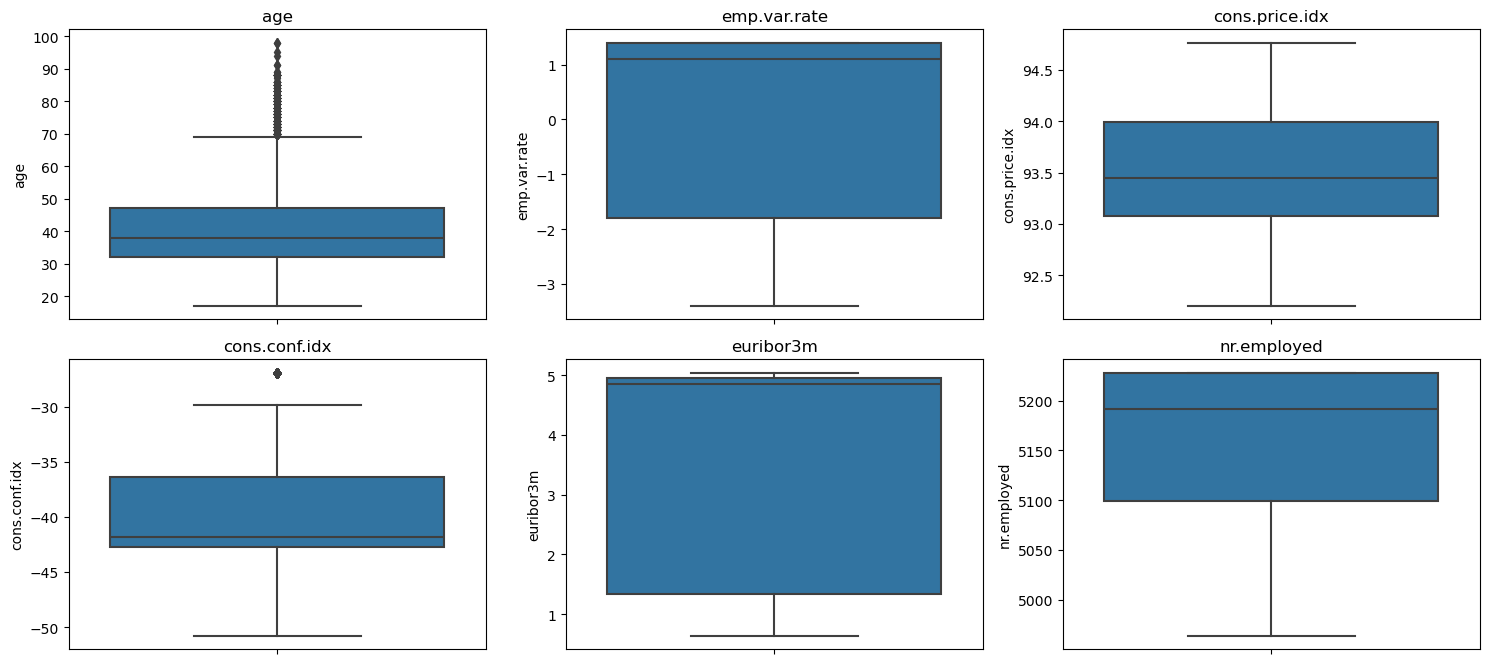

In [11]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_demo[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


It appears only `age` has some outliers. To even better understand the data, we make some histograms.

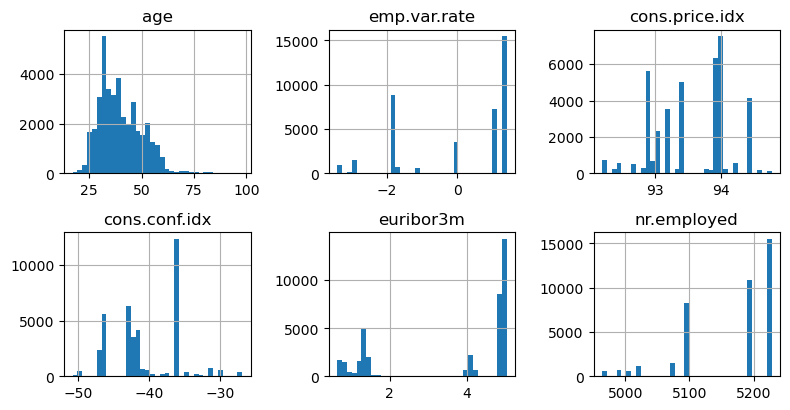

In [12]:
# create a figure with histogram subplots
plt.figure(figsize=(8, 6))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_demo[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


## Feature engineering

In this section, we
- explain why we did not normalize data,
- label encode categorical variables,
- analyze possible correlations between variables,
- and make sampling considerations.

### Normalize numerical columns
Since the numerical columns are not highly skewed, we decided against normalization of these columns

### Label encoding of categorical features
The categorical variables all contains string values. These are hard to process for clustering or modeling algorithms. Therefore, they should be encoded.

Considering one-hot encoding would result in a large amount of extra columns, we decided to use label encoding.

In [13]:
df_demo_encoded = df_demo #Copy dataset for encoding

# Apply label encoding to categorical columns
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    ids = le.fit_transform(df_demo_encoded[column])
    df_demo_encoded[column] = ids
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    label_mappings.update(mapping)

#Encode the target variable
df_demo_encoded['y'] = df_demo_encoded['y'].map({'yes': 1, 'no': 0})
print(label_mappings)

{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'divorced': 0, 'married': 1, 'single': 2, 'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6}


C:\Users\kyrii\AppData\Local\Temp\ipykernel_16036\1161805202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\kyrii\AppData\Local\Temp\ipykernel_16036\1161805202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\kyrii\AppData\Local\Temp\ipykernel_16036\1161805202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### Correlation matrices

Firstly, we make a correlation matrix that includes all variables.

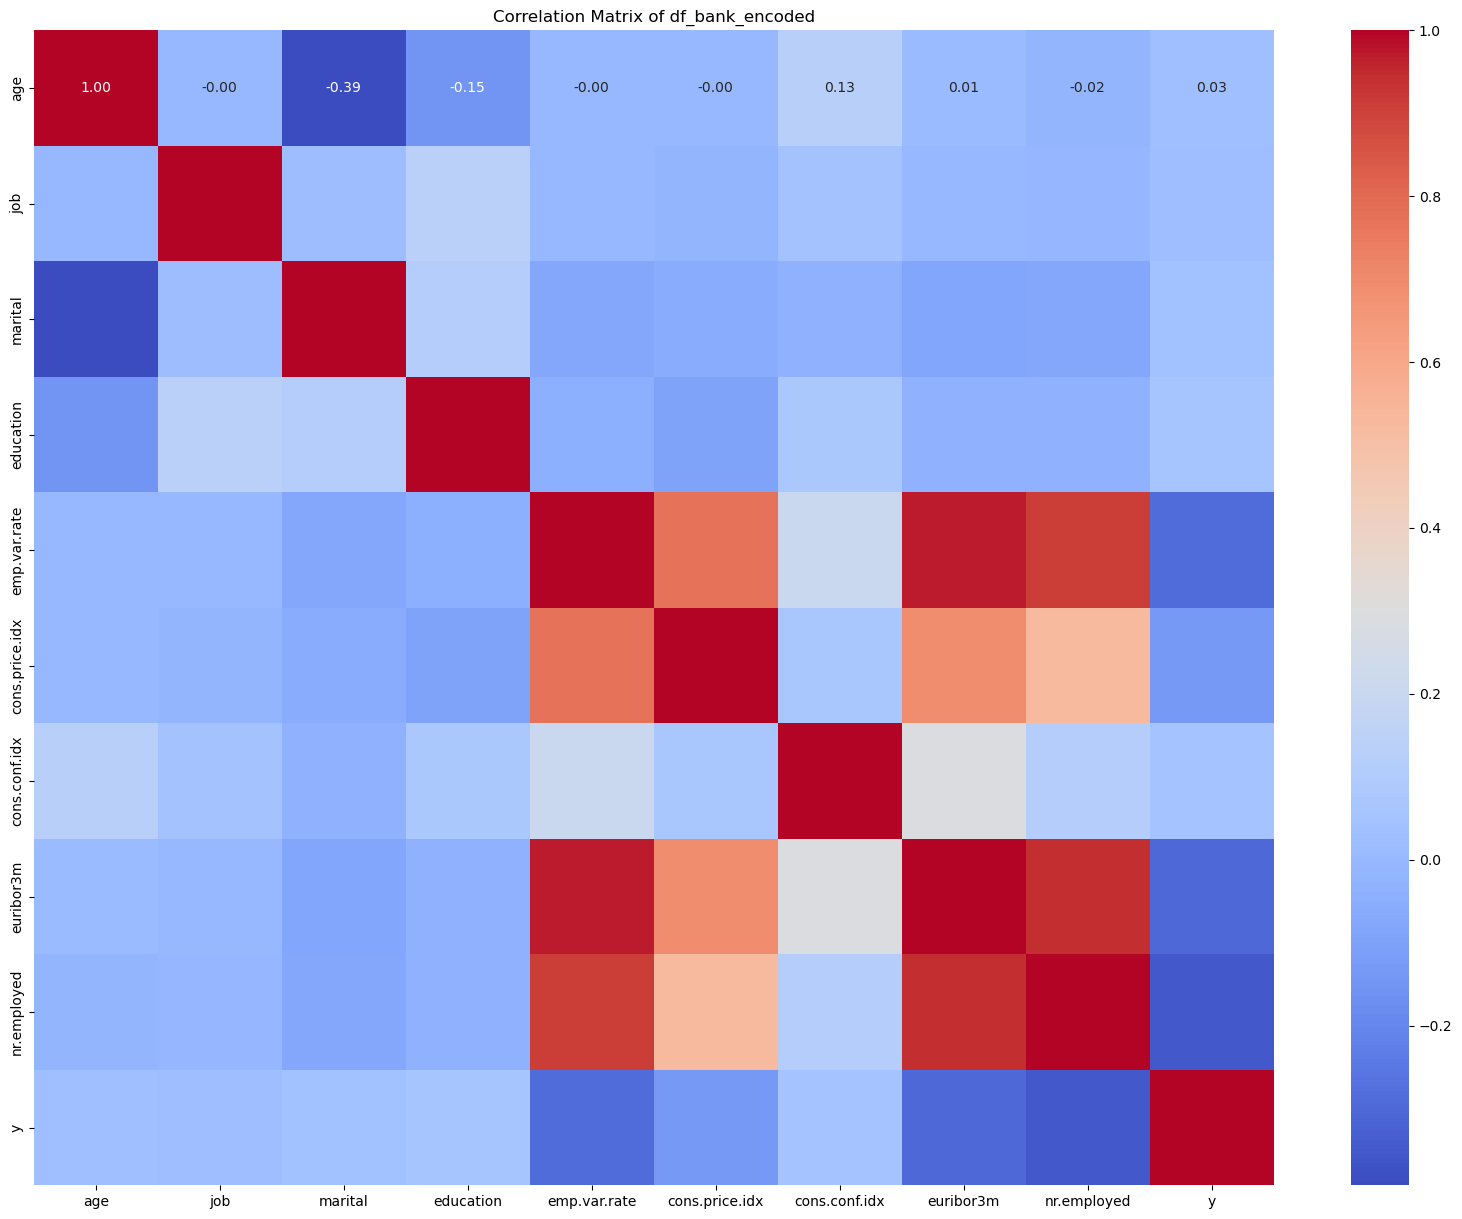

In [14]:
# Calculate the correlation matrix
correlation_matrix = df_demo_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_bank_encoded')
plt.show()

- Employment-Related Variables: There's a strong positive correlation between `emp.var.rate`, `cons.price.idx`, `euribor3m`, and `nr.employed`. This suggests that changes in employment rates significantly impact consumer prices, interest rates, and the number of employed individuals. A decrease in employment rates leads to a decrease in consumer prices, an increase in interest rates, and a reduction in the number of people employed. <br>
  Especially the correlation between `emp.var.rate` and `nr.employed` is logical because they both explain employment.
- Demographical variables: There is a weak to no correlation between the categorical variables `job`, `marital`, and `education` and any other variable. This would indicate they are independent.


**NOTE:** The variables `job`, `marital`, and `education` seem to have a weak to low crrelation. However, they are label encoded, thus the correlation might not capture the true relationships.

We are interested in which variables correlate with the target variable the most, therefore, we select all correlations with `y` and sort the absolute values from high to low. We sort on absolute values, since a strong negative effect is also an effect we would like to observe.

In [15]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_demo_encoded.corr()[['y']]
print(y_corr)

                       y
age             0.030557
job             0.020840
marital         0.041972
education       0.054412
emp.var.rate   -0.293264
cons.price.idx -0.133833
cons.conf.idx   0.051365
euribor3m      -0.302094
nr.employed    -0.349526
y               1.000000


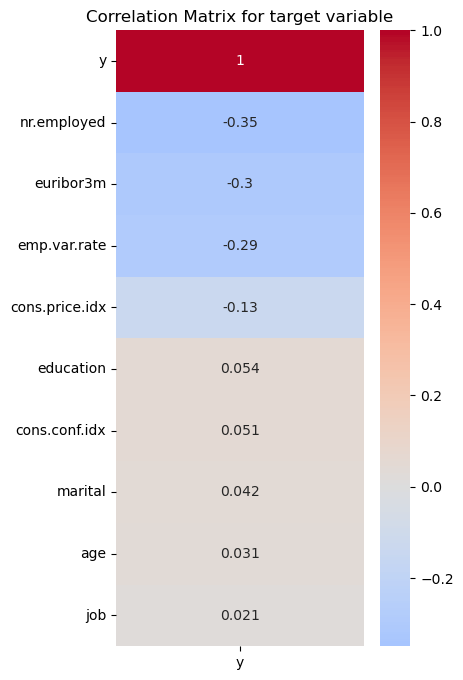

In [16]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
#filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]
filtered_corr_matrix = y_corr

#Sort the values by the absolute value of correlation for visualization purposes
filtered_corr_matrix = filtered_corr_matrix.reindex(filtered_corr_matrix['y'].abs().sort_values(ascending=False).index)

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(4, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for target variable')
plt.show()

- *Strong **positive** correlation* between `y` and `emp.var.rate`, `cons.price.idx`, `euribor3m`, and `nr.employed`. This strong correlation between them might indicate they are good predictors.
- *Moderate **positive** correlation* between `y` and `cons.conf.idx`. This suggests  this variable also has some predictive power, though it's not as strong as the other variables mentioned above.
- *Weak **positive** correlation* between `y` and `education`. This implies there's a slightly positive association between education and the target variable.
- *Low to no correlation* between `y` and `age`, `job`, and `marital`. This suggests these variables might not be significant predictors for the target variable.

**NOTE:** Again, the variables `education`, `marital` and `job` seem to have a weak to low correlation. However, they are label encoded, thus the correlation might not capture the true relationships.

### Sampling considerations
The proportion of positive outcomes against negative outomces is inbalanced, and leans heavily into the negative outcomes. Still, we have decided NOT to resample this, and instead use the imbalanced dataset. We will evaluate the models based on the AUC, which is a better metric for imbalanced datasets. This will also be explained later in the notebook.

In [17]:
# Separate majority and minority classes
df_majority = df_demo_encoded[df_demo_encoded['y'] == 0]
df_minority = df_demo_encoded[df_demo_encoded['y'] == 1]
print("Succesfull calls (Subscriptions to term deposit, y=1):", df_minority.shape[0])
print("Unsuccesfull calls (no subscription, y=0):", df_majority.shape[0])

Succesfull calls (Subscriptions to term deposit, y=1): 4360
Unsuccesfull calls (no subscription, y=0): 34831


## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

We need to create the clusters without our outcome variable 'y', therefore we drop the column.

In [18]:
df_demo_encoded_no_y = df_demo_encoded.drop(columns=['y'])
df_demo_encoded_no_y.head()

age  job  marital  education  emp.var.rate  cons.price.idx  cons.conf.idx  \
0   56    3        1          0           1.1          93.994          -36.4   
1   57    7        1          3           1.1          93.994          -36.4   
2   37    7        1          3           1.1          93.994          -36.4   
3   40    0        1          1           1.1          93.994          -36.4   
4   56    7        1          3           1.1          93.994          -36.4   

   euribor3m  nr.employed  
0      4.857       5191.0  
1      4.857       5191.0  
2      4.857       5191.0  
3      4.857       5191.0  
4      4.857       5191.0

### Cluster algorithm 1 - DBSCAN

In order to find the optimal parameters for the DBSCAN clusters, we will need to first make a rough estimation. To this end, we will create an elbow plot based on NearestNeighbors. (https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan)

In [19]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_demo_encoded_no_y)
distances, indices = neighbors_fit.kneighbors(df_demo_encoded_no_y)
distances = np.sort(distances, axis=0)[:,1]


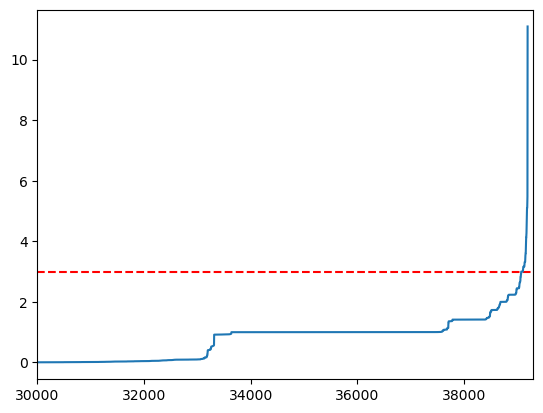

In [20]:
plt.xlim(30000, 39300)
plt.axhline(y=3, color='r', linestyle='--')
plt.plot(distances)

From the (zoomed in) elbow plot, we find that our optimal value of epsilon would be within the range of 2 and 4 for the epsilon.

The minimum samples has a recommendation to take the amount of parameters as its minimum, and we have set the maximum to 10 higher due to time constraints.

We calculate each combination of eps values and minimum sample values, and for each combination we calculate the silhouette score. We will select the combination with the highest silhouette score.

Throughout the process, we found that the range for epsilon was not wide enough, and when we took a wider range of 2 to 10, we found that a value around 8.2 gave the highest score. In order to not have this cell run for a very long time, we have adjusted the range of the score to our found optimum.

In [21]:
# Define a range of eps and min_samples values to test
eps_values = np.arange(8, 8.4, 0.2)  # Adjust the range and step as necessary
min_samples_values = range(9, 10)

# Dictionary to store the results
best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_demo_encoded_no_y)
        
        # Only compute silhouette score if there is more than 1 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(df_demo_encoded_no_y, labels)
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
            # Check if this is the best score
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best params: {best_params}, Best silhouette score: {best_score}")


eps: 8.0, min_samples: 9, silhouette score: 0.5972067797409846
eps: 8.2, min_samples: 9, silhouette score: 0.5972895546120037
eps: 8.399999999999999, min_samples: 9, silhouette score: 0.5972895546120037
Best params: {'eps': 8.2, 'min_samples': 9}, Best silhouette score: 0.5972895546120037


Using the calculated best parameters, we will create the DBSCAN clusters using sklearn.cluster.DBSCAN. We will add these clusters to the full dataset, so the dataset in which the column 'y' is included.

In [23]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])

df_demo_encoded['dbscan_cluster'] = dbscan.fit_predict(df_demo_encoded_no_y)

Check how many different clusters are created

In [24]:
(df_demo_encoded['dbscan_cluster'].unique())

array([ 0,  1, -1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

We would like to create the cluster plots without the 'y' column, so we will create a new dataframe in which it's dropped.

In [25]:
df_demo_encoded_dbscan = df_demo_encoded.drop(['y'], axis=1)

For our convenience, we will create the variable 'dbscan_features', which includes the exploratory variables that we will include.

In [26]:
dbscan_features = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Here is where we will plot the DBSCAN clusters for all variables, using the previously created dataframe.

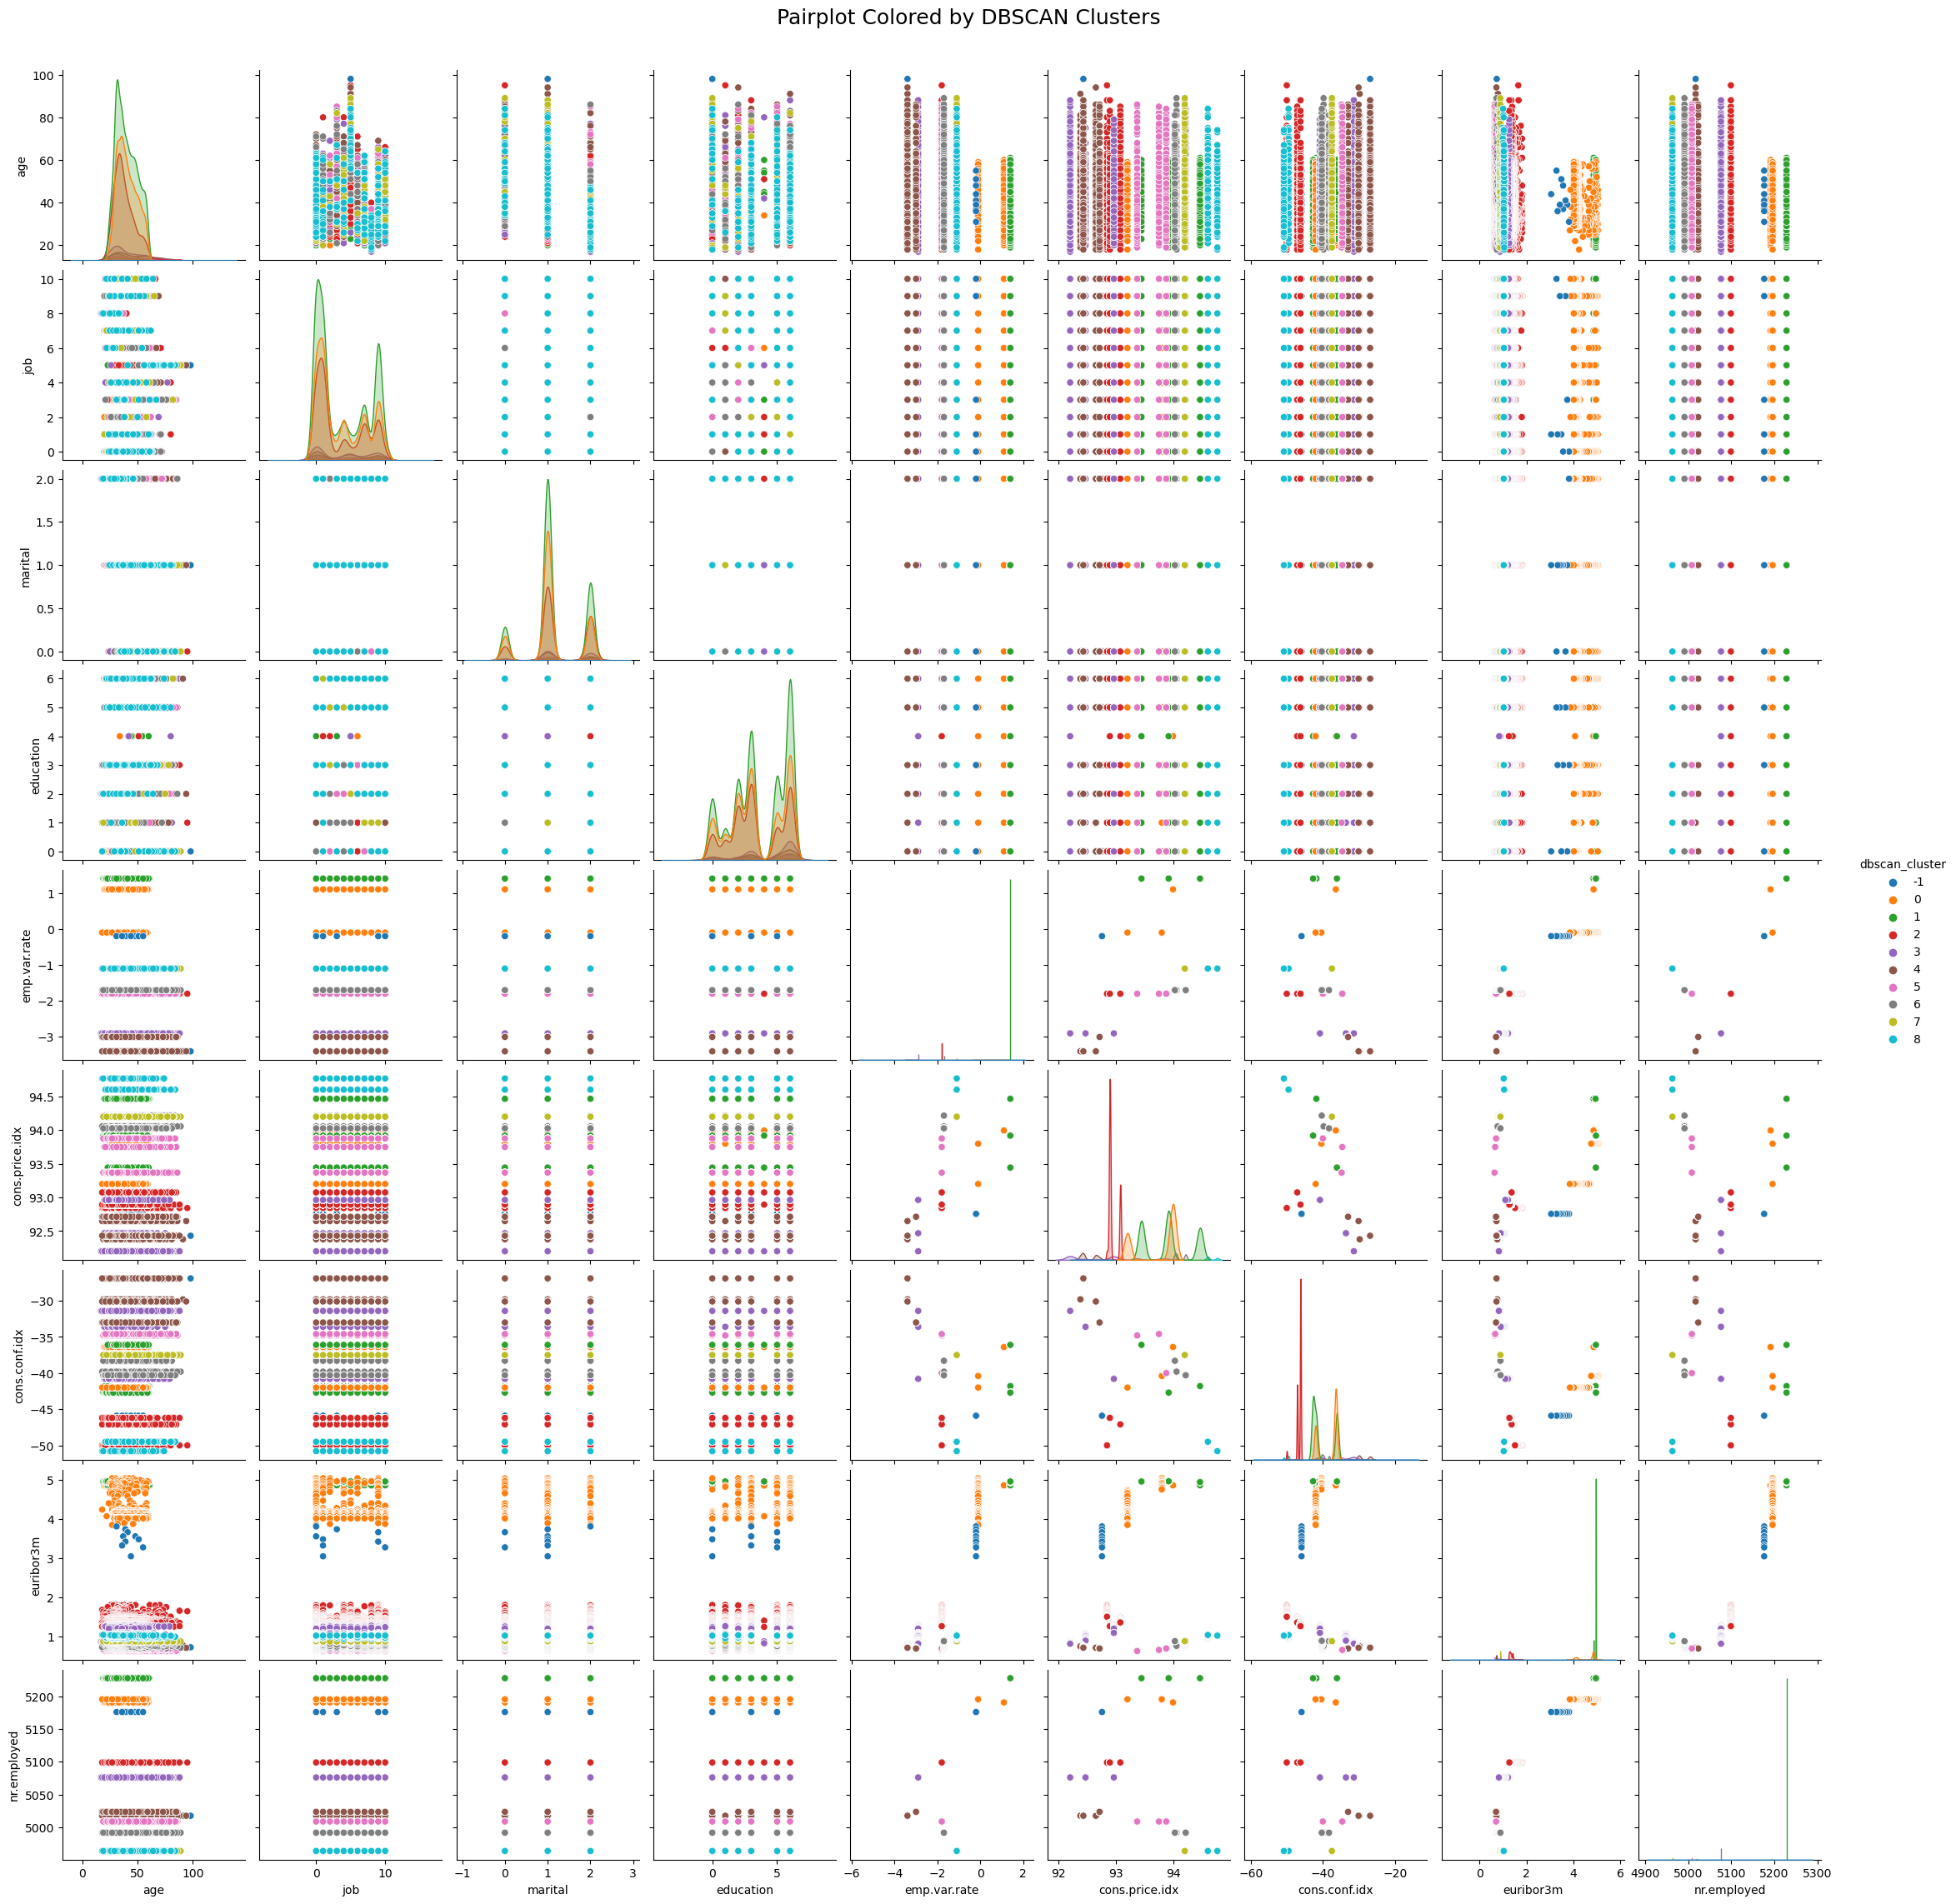

In [27]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_demo_encoded_dbscan, vars=df_demo_encoded_dbscan[dbscan_features], 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02, size=18)
plt.show()

We have found 8 informative clusters, as the cluster denoted as '-1' is considered the 'noise' cluster. We will remove it to inspect the clusters further.

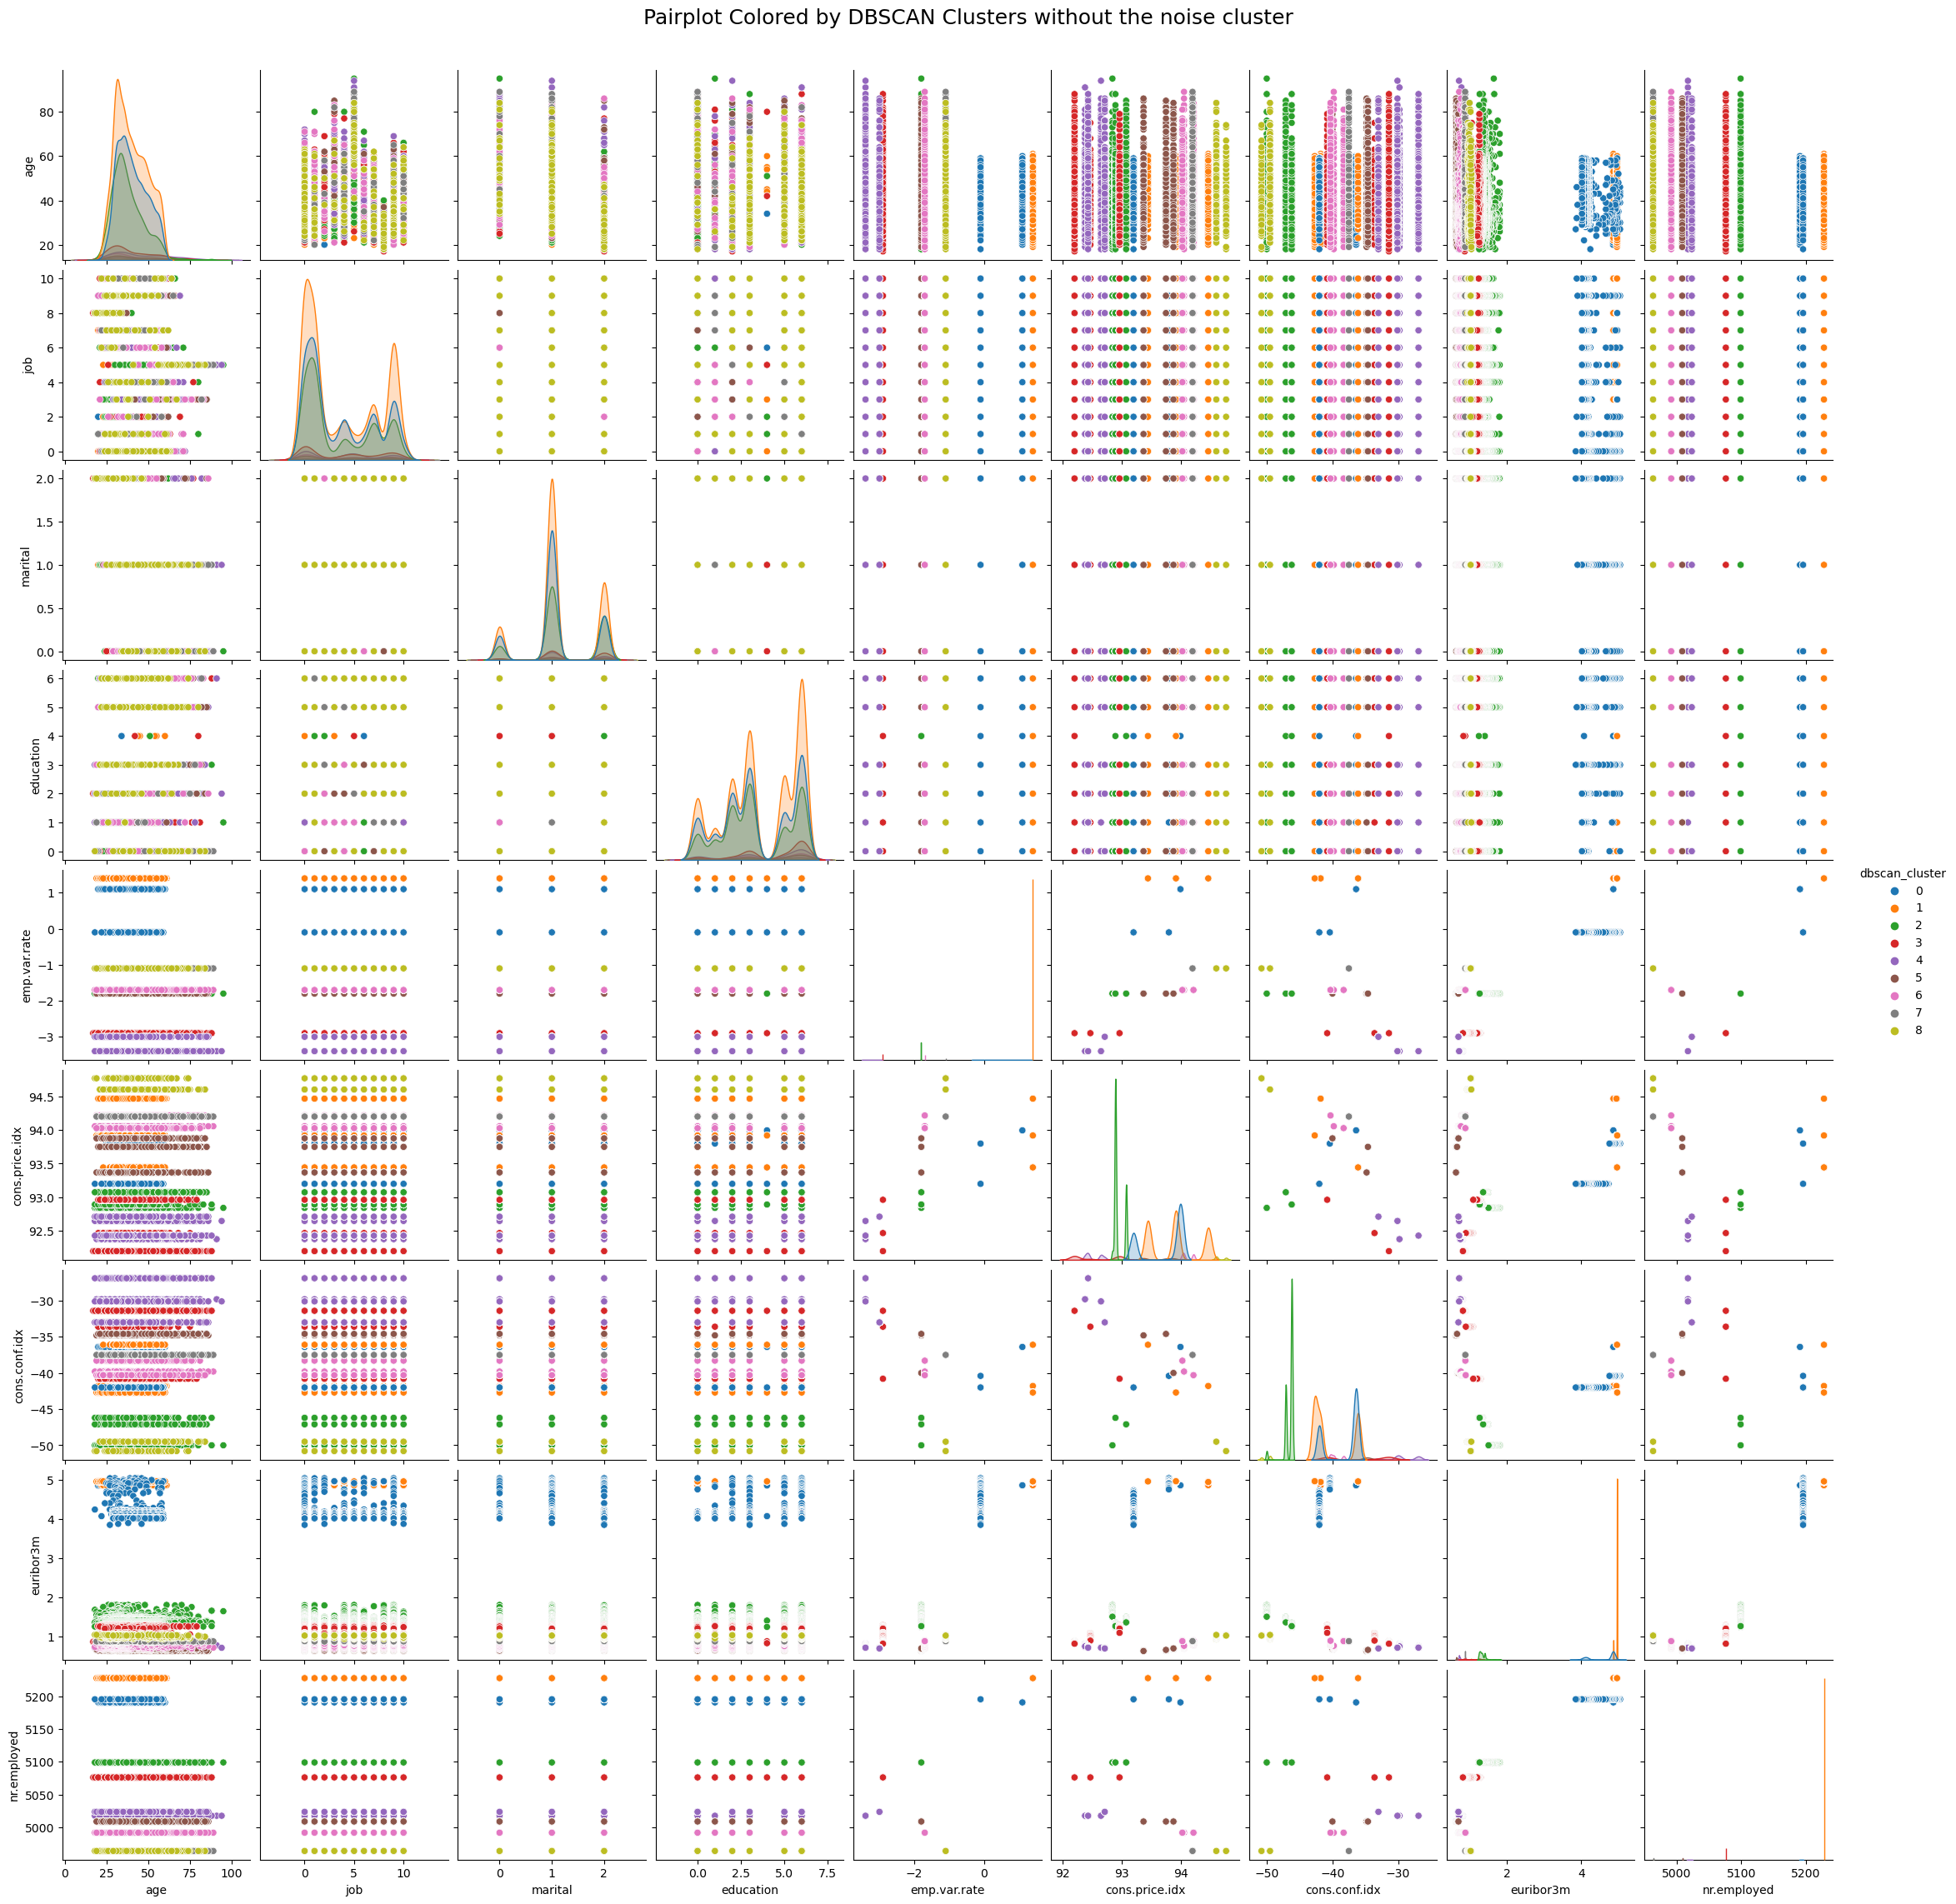

In [29]:
df_dbscan_no_noise = df_demo_encoded_dbscan[df_demo_encoded_dbscan['dbscan_cluster'] != -1]

# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_dbscan_no_noise, vars=df_dbscan_no_noise[dbscan_features], 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters without the noise cluster", y=1.02, size=18)
plt.show()

We notice that the clusters are not as well-defined as we would like them to be. Some plots do have clear clusters that seem to make sense, such as education and nr. employed, where the clusters seem to be based mostly on the nr. employed. Most plots however do not seem to have clear subgroups, making it difficult to derive insights from the DBSCAN plots.

Now we will check the silhouette scores of the DBSCAN clusters. The silhouette score is a score between -1 and 1, where a number closer to the positive 1 denotes better fitting clusters. 

In [30]:
dbscan_silhouette_score_no_noise = silhouette_score(df_dbscan_no_noise, df_dbscan_no_noise['dbscan_cluster'])
print('Silhouette score for the DBSCAN clusters without noise:', dbscan_silhouette_score_no_noise)
print('Silhouette score for the DBSCAN clusters with noise:', best_score)

Silhouette score for the DBSCAN clusters without noise: 0.5978170146974222
Silhouette score for the DBSCAN clusters with noise: 0.5972895546120037


Both scores score around the 0.59, which is not a bad score considering the range of the silhouette score.

We have a slightly smaller score when including the noise. Therefore, the noise may not make such a large difference. This could be due to a very small amount of noise:

In [31]:
print('Amount of rows where the row is defined as noise for clustering:', len(df_demo_encoded_dbscan[df_demo_encoded_dbscan['dbscan_cluster'] == -1]))

Amount of rows where the row is defined as noise for clustering: 12


### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [32]:
# Defining the cluster_range and accuracies for plotting process
cluster_range = range(2,11)
scores = []
all_clusters = []
data = df_demo_encoded_no_y

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_demo_encoded_no_y.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

    # Calculate silhouette scores
    score = silhouette_score(df_demo_encoded_no_y, clusters)
    scores.append(score)

print(scores)

[0.7683152401116762, 0.7775925942770727, 0.6901503786340556, 0.667310486283378, 0.5960413122867636, 0.4823892935128093, 0.45540511414914553, 0.40157661772413183, 0.40756467669682894]


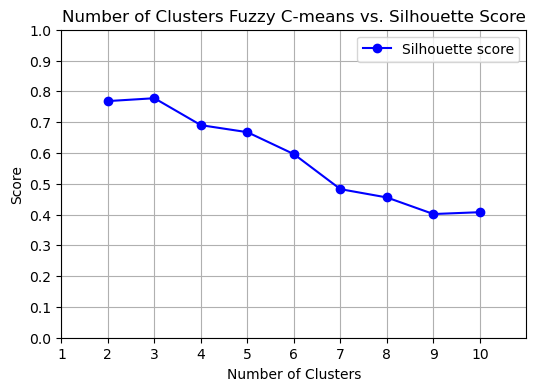

In [33]:
# Plotting number of clusters vs. silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(cluster_range, scores, marker='o', color='b', label="Silhouette score")
plt.title("Number of Clusters Fuzzy C-means vs. Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.xlim(1, 11)  # Setting x-axis limit
plt.ylim(0, 1)  # Setting y-axis limit
plt.xticks(range(1, 11))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

plt.show()

When we set the number of clusters to 2, we get the highest silhouette score of 0.7683152401116689. Therefore, we use this value for the final fuzzy c-means interpretation.

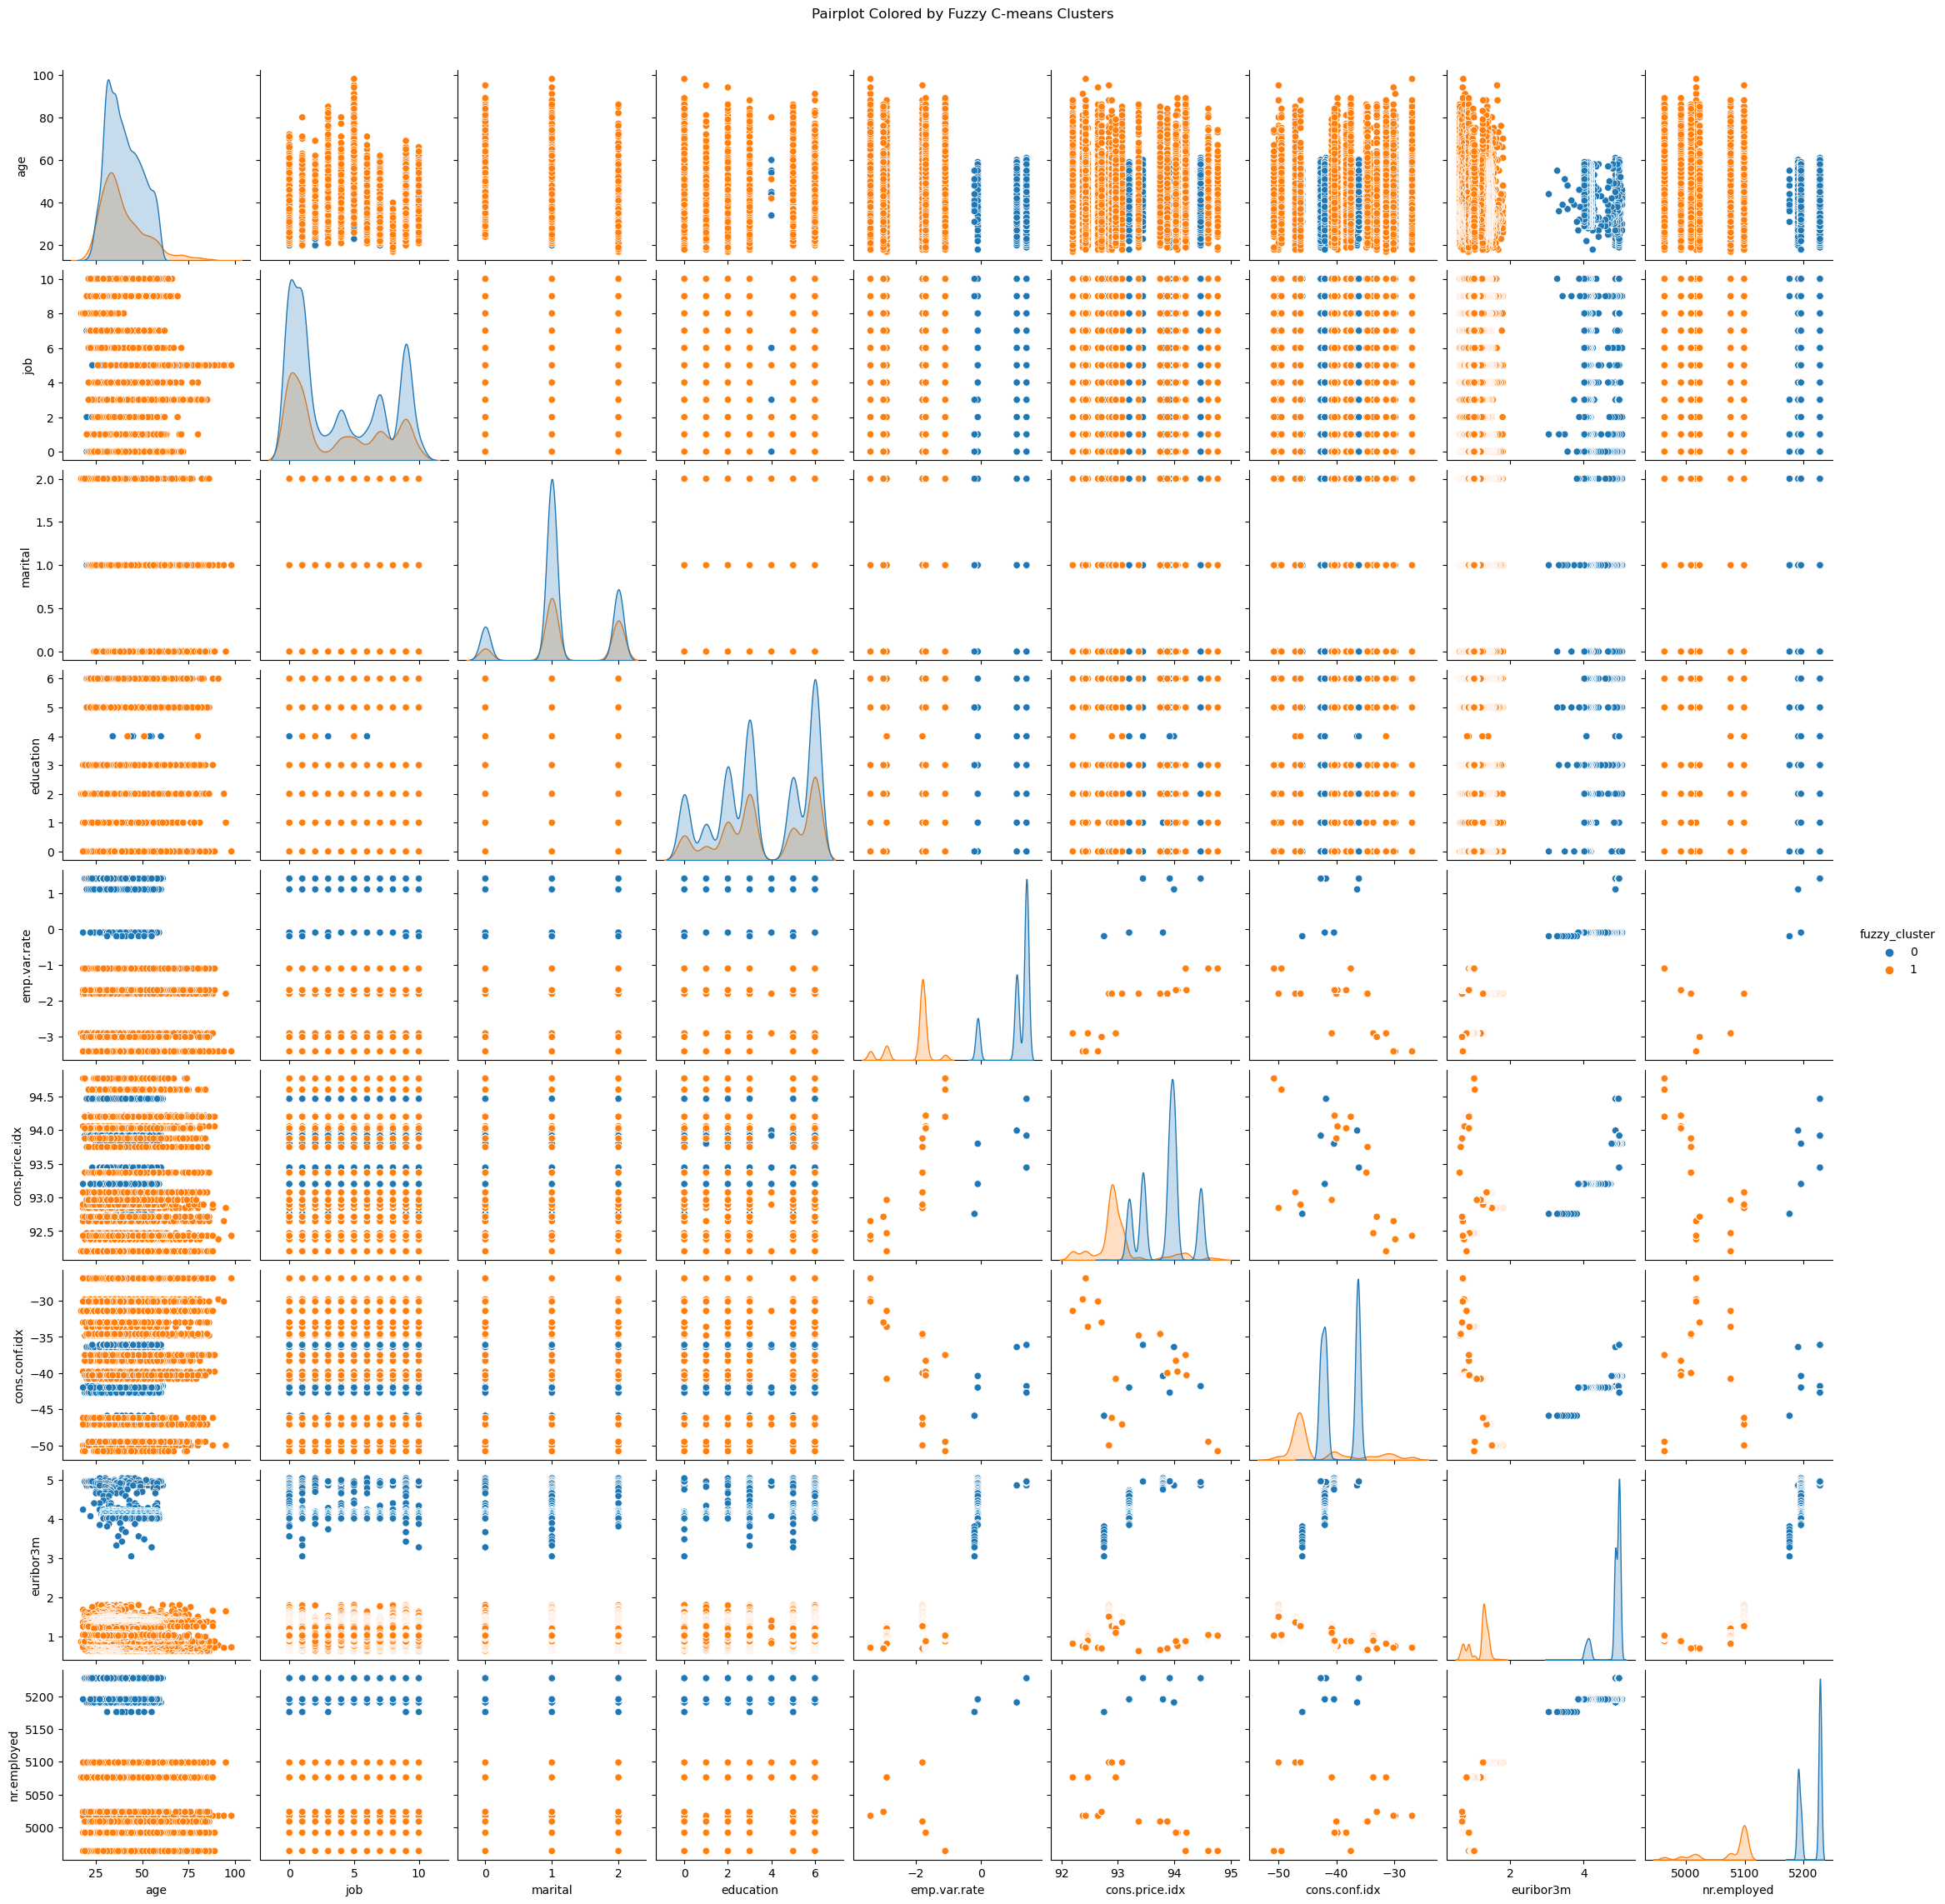

In [34]:
# Perform fuzzy c-means clustering with 2 clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, c=2, m=2, error=0.005, maxiter=1000)
clusters = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_demo_encoded['fuzzy_cluster'] = clusters

# Plot the clusters using pairplot
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, 
             hue='fuzzy_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by Fuzzy C-means Clusters", y=1.02)
plt.show()

In [35]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

Clusters centers: [[ 3.99889374e+01  3.65728670e+00  1.13129689e+00  3.58226864e+00
   1.10950624e+00  9.38370308e+01 -3.95019457e+01  4.80709510e+00
   5.21334527e+03]
 [ 3.93208992e+01  3.62300324e+00  1.24784891e+00  3.67532413e+00
  -2.04009752e+00  9.29968167e+01 -4.28461264e+01  1.19056209e+00
   5.07581796e+03]]
Memership matrix: [[0.94594393 0.94402007 0.96185563 ... 0.1709456  0.16887391 0.17881341]
 [0.05405607 0.05597993 0.03814437 ... 0.8290544  0.83112609 0.82118659]]


### Clustering Interpretation

## Association rules

We would like to see the implications of certain variables to other variables. Therefore, we will look into the association rules of our dataset.

However, we typically need categorical data for the method that we would like to use: apriori. Therefore, we will segment the numerical variables that we have chosen in order to still include them. We will do this using equal-width bins, in order to keep the distribution of the original data. We will only apply this to the numerical variables where the variety in values is high enough for us to deem it necessary. For example, emp.var.rate has a limited amount of possibilities, which makes it fine to not bin it.

For the association rules, we want to make use of df_demo, as we are able to use the unencoded data.

In [45]:
df_ass_rules = df_demo
df_ass_rules

age          job  marital            education  emp.var.rate  \
0       56    housemaid  married             basic.4y           1.1   
1       57     services  married          high.school           1.1   
2       37     services  married          high.school           1.1   
3       40       admin.  married             basic.6y           1.1   
4       56     services  married          high.school           1.1   
...    ...          ...      ...                  ...           ...   
41183   73      retired  married  professional.course          -1.1   
41184   46  blue-collar  married  professional.course          -1.1   
41185   56      retired  married    university.degree          -1.1   
41186   44   technician  married  professional.course          -1.1   
41187   74      retired  married  professional.course          -1.1   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed    y  
0              93.994          -36.4      4.857       5191.0   no  
1              93.994          -36.4      4.857       5191.0   no  
2              93.994          -36.4      4.857       5191.0   no  
3              93.994          -36.4      4.857       5191.0   no  
4              93.994          -36.4      4.857       5191.0   no  
...               ...            ...        ...          ...  ...  
41183          94.767          -50.8      1.028       4963.6  yes  
41184          94.767          -50.8      1.028       4963.6   no  
41185          94.767          -50.8      1.028       4963.6   no  
41186          94.767          -50.8      1.028       4963.6  yes  
41187          94.767          -50.8      1.028       4963.6   no  

[41188 rows x 10 columns]

#### Translation of the categories to their actual values

In [43]:
# Categories for age
count = 1
for interval in pd.qcut(df_ass_rules['age'], q=5).cat.categories:
        print('Age category', count, ':', interval)
        count +=1

Age category 1 : (16.999, 31.0]
Age category 2 : (31.0, 35.0]
Age category 3 : (35.0, 41.0]
Age category 4 : (41.0, 49.0]
Age category 5 : (49.0, 98.0]


In [46]:
# Categories for emp.var.rate
count = 1
for interval in pd.qcut(df_ass_rules['emp.var.rate'], q=3).cat.categories:
        print('emp.var.rate category', count, ':', interval)
        count +=1

ValueError: Bin edges must be unique: Index([-3.4, -0.1, 1.4, 1.4], dtype='float64', name='emp.var.rate').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [252]:
# Categories for cons.price.idx
count = 1
for interval in pd.qcut(df_ass_rules['cons.price.idx'], q=3).cat.categories:
        print('cons.price.idx category', count, ':', interval)
        count +=1

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [253]:
# Categories for cons.conf.idx
count = 1
for interval in pd.qcut(df_ass_rules['cons.conf.idx'], q=3).cat.categories:
        print('cons.conf.idx category', count, ':', interval)
        count +=1

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
# Categories for euribor3m
count = 1
for interval in pd.qcut(df_ass_rules['euribor3m'], q=10).cat.categories:
        print('euribor3m category', count, ':', interval)
        count +=1

euribor3m category 1 : (0.633, 1.046]
euribor3m category 2 : (1.046, 1.299]
euribor3m category 3 : (1.299, 1.41]
euribor3m category 4 : (1.41, 4.191]
euribor3m category 5 : (4.191, 4.857]
euribor3m category 6 : (4.857, 4.864]
euribor3m category 7 : (4.864, 4.96]
euribor3m category 8 : (4.96, 4.962]
euribor3m category 9 : (4.962, 4.964]
euribor3m category 10 : (4.964, 5.045]


In [48]:
# Categories for nr. employed
count = 1
for interval in pd.qcut(df_ass_rules['nr.employed'], q=3).cat.categories:
        print('nr.employed category', count, ':', interval)
        count +=1

ValueError: Bin edges must be unique: Index([4963.6, 5191.0, 5228.1, 5228.1], dtype='float64', name='nr.employed').
You can drop duplicate edges by setting the 'duplicates' kwarg

#### Encoding the numerical variables to categorical variables

In [49]:
# Encoding of age
num_bins = 5
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['age'] = pd.cut(df_ass_rules['age'], bins=num_bins, labels=labels)


In [50]:
# Encoding of cons.price.idx
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['cons.price.idx'] = pd.cut(df_ass_rules['cons.price.idx'], bins=num_bins, labels=labels)

In [249]:
# Encoding of cons.conf.idx
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['cons.conf.idx'] = pd.cut(df_ass_rules['cons.conf.idx'], bins=num_bins, labels=labels)

C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\1041307201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['cons.conf.idx'] = pd.cut(df_ass_rules['cons.conf.idx'], bins=num_bins, labels=labels)


In [212]:
# Encoding of euribor3m
num_bins = 10
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['euribor3m'] = pd.cut(df_ass_rules['euribor3m'], bins=num_bins, labels=labels)


C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\4126262756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['euribor3m'] = pd.cut(df_ass_rules['euribor3m'], bins=num_bins, labels=labels)


In [243]:
# Encoding of nr.employed
num_bins = 3
labels = ['Category ' + str(i+1) for i in range(num_bins)]  # Create labels for the bins

# Use pd.cut to categorize 'age' into 5 equal-width bins
df_ass_rules['nr.employed'] = pd.cut(df_ass_rules['nr.employed'], bins=num_bins, labels=labels)

C:\Users\20202631\AppData\Local\Temp\ipykernel_14232\2191617595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ass_rules['nr.employed'] = pd.cut(df_ass_rules['nr.employed'], bins=num_bins, labels=labels)


This is our final encoded dataset, so we can use it for the apriori algorithm.

In [51]:
df_ass_rules.head()

age        job  marital    education  emp.var.rate cons.price.idx  \
0  Category 3  housemaid  married     basic.4y           1.1     Category 3   
1  Category 3   services  married  high.school           1.1     Category 3   
2  Category 2   services  married  high.school           1.1     Category 3   
3  Category 2     admin.  married     basic.6y           1.1     Category 3   
4  Category 3   services  married  high.school           1.1     Category 3   

   cons.conf.idx  euribor3m  nr.employed   y  
0          -36.4      4.857       5191.0  no  
1          -36.4      4.857       5191.0  no  
2          -36.4      4.857       5191.0  no  
3          -36.4      4.857       5191.0  no  
4          -36.4      4.857       5191.0  no

The bins that were selected were based on the amount of variety in each variable. The ones that had very little variety received 3 bins, medium 5 and a large amount of variety resulted in 10 bins.

#### Checking the bar plots of our categories

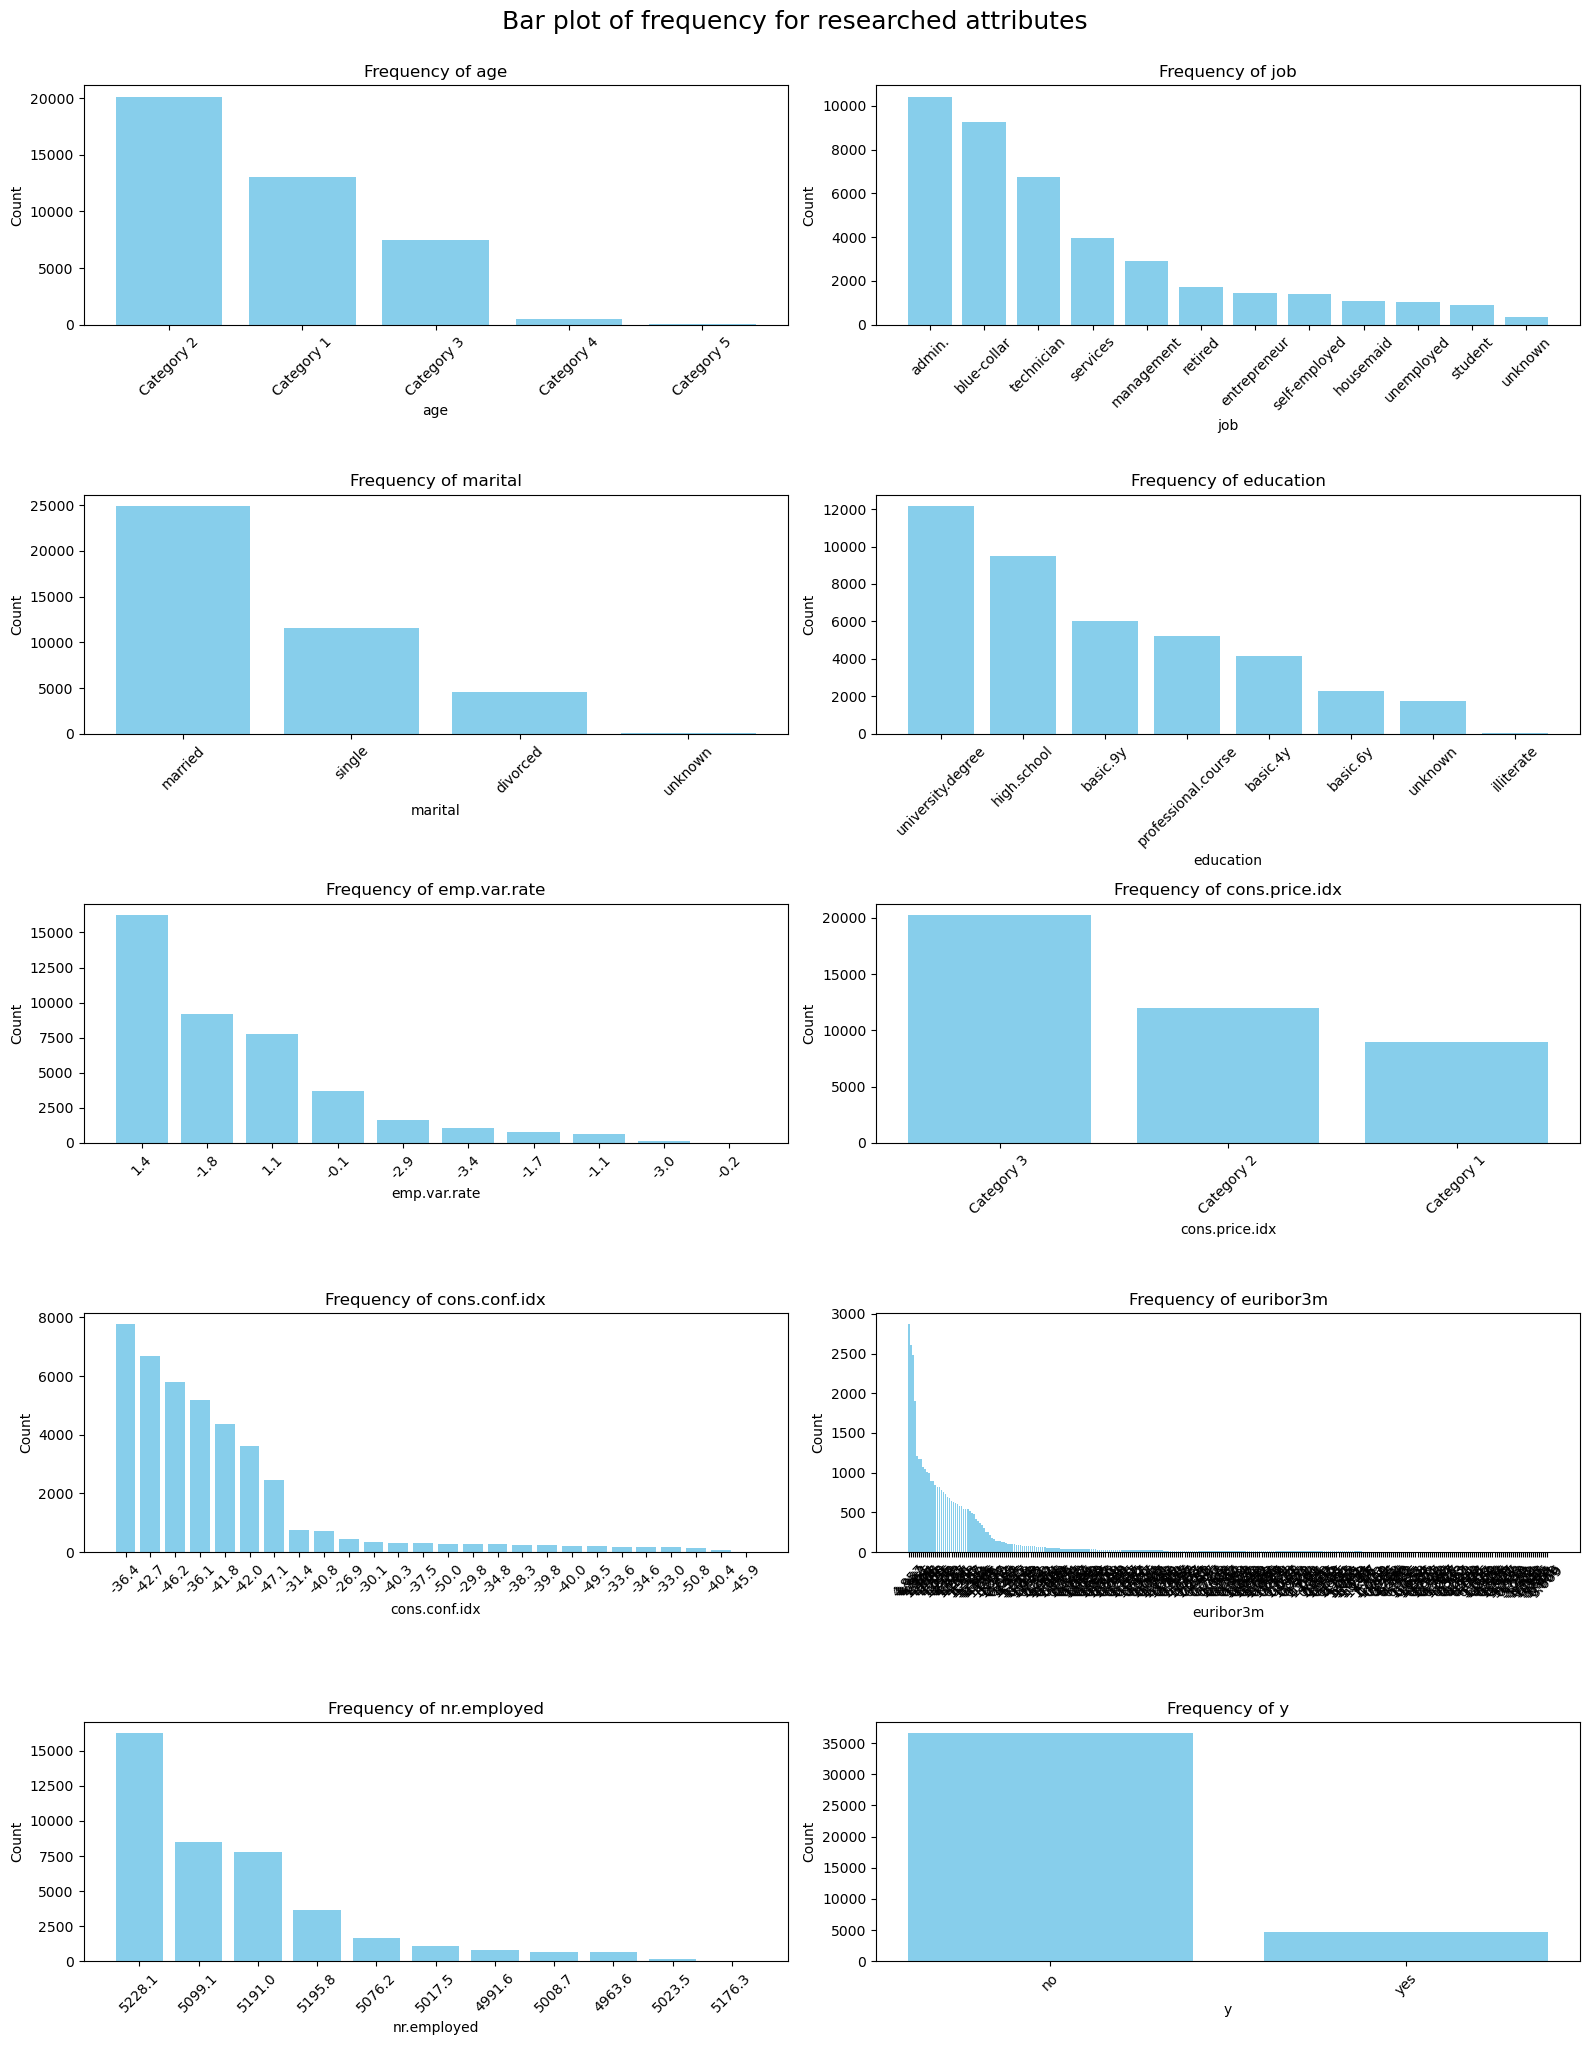

In [52]:
ass_rules_features = dbscan_features + ['y']

fig, ax = plt.subplots(5, 2, figsize=(16, 20))

# Flatten the axes to make it easier to loop through
ax = ax.flatten()

# Loop through the categorical columns and create bar plots
for i, column in enumerate(ass_rules_features):
    # Get the counts of each category in the column
    value_counts = df_ass_rules[column].value_counts()
    
    # Plot the bar plot for the current column
    ax[i].bar(value_counts.index.astype(str), value_counts, color='skyblue')
    ax[i].set_title(f'Frequency of {column}')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust the layout to avoid overlap
plt.tight_layout()
fig.suptitle('Bar plot of frequency for researched attributes', y=1.02, size=18)
# Show the plots
plt.show()


From the bar plot, we notice that some 'items' are much more frequent than others, which could lead to intersting association rules.

In order to implement the apriori algorithm, we will need to apply some data preprocessing. All the values need to be 0 or 1 for it to work, so we will use the 'get_dummies' algorithm from python to ensure this.

In [53]:
df_ass_rules = pd.get_dummies(df_ass_rules)
df_ass_rules.head()

emp.var.rate  cons.conf.idx  euribor3m  nr.employed  age_Category 1  \
0           1.1          -36.4      4.857       5191.0           False   
1           1.1          -36.4      4.857       5191.0           False   
2           1.1          -36.4      4.857       5191.0           False   
3           1.1          -36.4      4.857       5191.0           False   
4           1.1          -36.4      4.857       5191.0           False   

   age_Category 2  age_Category 3  age_Category 4  age_Category 5  job_admin.  \
0           False            True           False           False       False   
1           False            True           False           False       False   
2            True           False           False           False       False   
3            True           False           False           False        True   
4           False            True           False           False       False   

   ...  education_high.school  education_illiterate  \
0  ...                  False                 False   
1  ...                   True                 False   
2  ...                   True                 False   
3  ...                  False                 False   
4  ...                   True                 False   

   education_professional.course  education_university.degree  \
0                          False                        False   
1                          False                        False   
2                          False                        False   
3                          False                        False   
4                          False                        False   

   education_unknown  cons.price.idx_Category 1  cons.price.idx_Category 2  \
0              False                      False                      False   
1              False                      False                      False   
2              False                      False                      False   
3              False                      False                      False   
4              False                      False                      False   

   cons.price.idx_Category 3  y_no  y_yes  
0                       True  True  False  
1                       True  True  False  
2                       True  True  False  
3                       True  True  False  
4                       True  True  False  

[5 rows x 38 columns]

In [54]:
# 65% support is used to create a smaller set.
frequent_items = apriori(df_ass_rules, min_support=0.65, use_colnames=True)
frequent_items

ValueError: The allowed values for a DataFrame are True, False, 0, 1. Found value 1.1

These results indicate how often these itemsets occur in the entire dataset, showing us that for example y_no (meaning that no loan was taken) occurs 88.73% of the time.


In [314]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.3)
rules_13 = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(13)
rules_13

antecedents  \
2                           (emp.var.rate_Category 3)   
3                            (nr.employed_Category 3)   
8   (emp.var.rate_Category 3, cons.conf.idx_Catego...   
10  (cons.conf.idx_Category 2, nr.employed_Categor...   
11                          (emp.var.rate_Category 3)   
13                           (nr.employed_Category 3)   
0                           (emp.var.rate_Category 3)   
5                            (nr.employed_Category 3)   
9   (emp.var.rate_Category 3, nr.employed_Category 3)   
1                          (cons.conf.idx_Category 2)   
4                          (cons.conf.idx_Category 2)   
12                         (cons.conf.idx_Category 2)   
6                          (cons.conf.idx_Category 2)   

                                          consequents  antecedent support  \
2                            (nr.employed_Category 3)            0.672283   
3                           (emp.var.rate_Category 3)            0.672283   
8                            (nr.employed_Category 3)            0.672040   
10                          (emp.var.rate_Category 3)            0.672040   
11  (cons.conf.idx_Category 2, nr.employed_Categor...            0.672283   
13  (emp.var.rate_Category 3, cons.conf.idx_Catego...            0.672283   
0                          (cons.conf.idx_Category 2)            0.672283   
5                          (cons.conf.idx_Category 2)            0.672283   
9                          (cons.conf.idx_Category 2)            0.672283   
1                           (emp.var.rate_Category 3)            0.720671   
4                            (nr.employed_Category 3)            0.720671   
12  (emp.var.rate_Category 3, nr.employed_Category 3)            0.720671   
6                                              (y_no)            0.720671   

    consequent support   support  confidence      lift  leverage  conviction  \
2             0.672283  0.672283    1.000000  1.487468  0.220319         inf   
3             0.672283  0.672283    1.000000  1.487468  0.220319         inf   
8             0.672283  0.672040    1.000000  1.487468  0.220239         inf   
10            0.672283  0.672040    1.000000  1.487468  0.220239         inf   
11            0.672040  0.672040    0.999639  1.487468  0.220239  908.120132   
13            0.672040  0.672040    0.999639  1.487468  0.220239  908.120132   
0             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
5             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
9             0.720671  0.672040    0.999639  1.387094  0.187545  773.461809   
1             0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
4             0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
12            0.672283  0.672040    0.932520  1.387094  0.187545    4.856524   
6             0.887346  0.665388    0.923289  1.040507  0.025904    1.468561   

    zhangs_metric  
2        1.000000  
3        1.000000  
8        0.999260  
10       0.999260  
11       1.000000  
13       1.000000  
0        0.851554  
5        0.851554  
9        0.851554  
1        0.999068  
4        0.999068  
12       0.999068  
6        0.139370

Taking our 13 highest confidence rules, we find that the values of all these rules are incredibly high. The 14th rule had a confidence if approx. 0.7, which is still relatively high.

We find that most of these rules include nr.employed, cons.conf.idx and emp.var.rate as the consequent. Mainly the higher end of these categories are more frequently occuring.

We can read this table as 'the confidence of a rule tells us how certain we are that if the antecedent is given, the consequent will occur'.

The most interesting rule to note is the rule with as consequent y_no, and as antecendent cons.conf.idx of category 2 (medium), as we are interested in y as our outcome variable. This rule has a confidence of 0.923, which is very high.

In [290]:
# Lift Ratio > 1 indicates good influential rule 
rules[(rules.lift<1)]

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

All of our rules have a positive lift, meaning that there is no negative correlation between our items

### Visalising the confidence

In order to clearly see the rules in one go, we will visualise them using barplots. This will allow us to understand the confidence of the rules more easily.

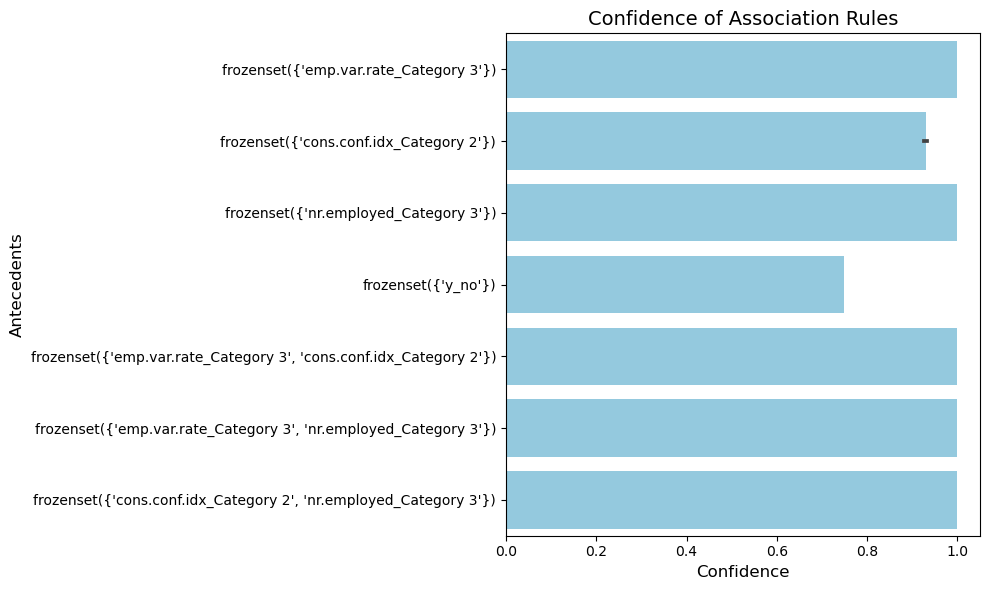

In [295]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents', data=rules, color='skyblue')

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

From this barplot we can see that the confidence for our rules is very high, and even our lowest ranking rule is still relatively high.

# Predictive Modelling


Now that we have performed EDA, feature engineering, clustering and association rule mining, we will move on to the predictive modelling part of the assignment. We will be using the following models:
- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- Random Forest

These models were chosen because they are known to perform well on imbalanced datasets, which we have. We will be using the AUC as our evaluation metric, as it is a better metric for imbalanced datasets than accuracy. After evluating all models the best performing will be chosen and finetuned for optimal performance.

First, we split the data into train and test data. We will use 80% of the data for training and 20% for testing. We will then train the models on the training data and evaluate them on the test data.

In [ ]:
#Split data into train and test data
X = df_demo_encoded.drop('y', axis=1)
y = df_demo_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Support Vector Machines (SVM)

Decision boundaries close to training points may generalize badly, since very similar (nearby) test points are classified as the other class.

Support Vector Machines (SVMs) try to solve these problems by employing a couple tricks:
- Choose a **boundary** that is as far away from training points as possible
- The **support vectors** are the training samples closest to the hyperplane
- The **margin** is the distance between the separating hyperplane and the _support vectors_

Hence, our objective with SVMs is to _maximize the margin_.

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Import SVC classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Import PCA
from sklearn.decomposition import PCA

In [ ]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line

    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()

SVM can only be applied to continuous numerical data. As such, we will use one-hot encoding for the categorical variables: 'marital', 'job', and 'education'.

In [ ]:
# Create a copy of X_train specifically for SVM processing, as we will be modifying it. This ensures that the later models will not affected by the modifications.
X_train_svm = X_train.copy()
X_test_svm = X_test.copy()

In [ ]:
# Apply one-hot encoding to the copied dataframes
X_train_svm = pd.get_dummies(X_train_svm, columns=['job', 'marital', 'education'])
X_test_svm = pd.get_dummies(X_test_svm, columns=['job', 'marital', 'education'])

# Align the columns in X_train_svm and X_test_svm to ensure they have the same features after encoding
X_train_svm, X_test_svm = X_train_svm.align(X_test_svm, join='left', axis=1, fill_value=0)

Secondly, due to the distinct natures of categorical and numerical data, we need to standardize the numerical variables in the dataset. This is because the SVM algorithm is sensitive to the scale of the input data. We will use the StandardScaler class from the sklearn.preprocessing module to standardize the numerical features in the dataset.

In [ ]:
# Identify numerical columns
numerical_cols = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns in the training set and apply the same transformation to the test set
X_train_svm[numerical_cols] = scaler.fit_transform(X_train_svm[numerical_cols])
X_test_svm[numerical_cols] = scaler.transform(X_test_svm[numerical_cols])

In [ ]:
X_train_svm.head()

In [ ]:
X_train_svm.shape

In [ ]:
# Then, for visualization purpose, we will reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_svm_reduced = pca.fit_transform(X_train_svm)
X_test_svm_reduced = pca.fit_transform(X_test_svm)

In [ ]:
X_test_svm_reduced.shape

Now that we have a reduced dataset, we can apply the grid search to find the best hyperparameters for the SVM model. We will use the GridSearchCV class from the sklearn.model_selection module to perform the grid search. We will use a 3-fold cross-validation to evaluate the performance of the model with different hyperparameters. We also need to include the class_weight='balanced' parameter to account for the imbalanced nature of the dataset.

In [ ]:
# Instantiate parameters and models
param_svc = {'kernel':['linear', 'poly', 'rbf'], 'C':[0.001, 0.10, 1, 10], 'class_weight': ['balanced', None]}
params = [param_svc]
models = [SVC()]

In [ ]:
xvals = [GridSearchCV(m, param, return_train_score = True, n_jobs = -1, verbose= True, cv=3, scoring = 'roc_auc').fit(X_train_svm_reduced, y_train) for m, param in zip(models, params)]

Then, we can print the table from the GridSearch

In [ ]:
results_df = pd.DataFrame(xvals[0].cv_results_)
results_df = results_df.sort_values('rank_test_score').reset_index()
results_df = results_df.drop(['index'], axis=1)
results_df.head(3)

As we can see in the table, the inclusion of the balanced parameter improves the performance of the model.

In [ ]:
# Filter the results for balanced models
balanced_results = results_df[results_df['param_class_weight'] == 'balanced']

# Display the top 3 results for balanced models
print("Top 3 Balanced Model Results:")
balanced_results[['params', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(3)

In [ ]:
# Filter the results for unbalanced models
unbalanced_results = results_df[results_df['param_class_weight'].isnull()]

# Display the top 3 results for unbalanced models
print("Top 3 Unbalanced Model Results:")
unbalanced_results[['params', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(3)

Now, we will extract the parameters from the best model and print them.

In [ ]:
# Extract best parameters and print them
best_params = results_df['params'][0]
print(best_params)

And then use these to fit the model again.

In [ ]:
# Fit the model with the best parameters
best_svc = SVC(**best_params)
best_svc.fit(X_train_svm_reduced, y_train)

Then, we will plot the decision boundaries of the SVM model, and the support vectors. We will take a sample size of 500 points to visualize this. 

In [ ]:
# For plotting, we'll use only 500 points
sample_size = 500

plot_svm_kernel(X_train_svm_reduced[:sample_size,], y_train[:sample_size,],best_params,
                best_svc.support_vectors_,
                best_svc.decision_function, best_svc.dual_coef_)

In this plot, we see the decision boundary of an SVM model with an RBF kernel, trained to predict whether individuals will subscribe to a term deposit based on several demographic and economic factors. Here are the key takeaways:

The RBF kernel allows the model to capture non-linear relationships among the factors influencing a subscription decision. This complexity indicates that the demographical and economic indicators interact in non-linear ways to affect the likelihood of subscription. However, since we have a relatively high C-value from the pre-defined parameters, this model might be prone to overfitting as when we would have chosen a lower C-value.

Additionally, by setting `class_weight='balanced'`, the model accounts for class imbalance, giving more weight to the minority class (which is in this case the positive outcomes)

Furthermore, the right side of the plot shows clusters where red and blue points are intermixed, indicating difficulty in distinguishing between subscribers and non-subscribers in this region of feature space. This overlap might reflect real-world ambiguity: for certain demographic or economic profiles, individuals could be equally likely to subscribe or not, meaning these features alone may not fully explain the decision to subscribe.

Lastly, the large number of support vectors (circled points) suggests that many data points are close to the decision boundary, indicating that the subscription decision is not clear-cut for most individuals. This aligns with the idea that small changes in someone's profile—such as slight variations in income or employment status—could impact their likelihood of subscribing.

### XGBoost

**XGBoost (Extreme Gradient Boosting)** is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for AUC) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [ ]:
#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)

After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [ ]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(X_train, y_train)

### Random Forest

**Decision Trees**, the building blocks of **Random Forests**, make decisions based on conditional splits at each node. These splits are determined by comparing feature values to a threshold and partitioning the data accordingly to minimize a cost function, often related to the impurity of the nodes (e.g., Gini impurity or entropy in classification problems). **Random Forests enhance the robustness of Decision Trees by creating an ensemble**. Each tree in the forest is trained on a random subset of the data (bootstrapped samples), and at each split, a random subset of features is considered. Compared to XGBoost, the Random Forest does not prune trees and can overfit if trees are fully grown. To avoid this, we wil first plot several different tree in terms of their dept. Besides that Random Forests struggle with imbalanced datasets (often biased towards majority class). In our case this is y=0. As our dataset is highly imbalanced, we will use the `stratify` parameter in the train test split function.

In order to assess the performance of the `RandomForestClassifier` across tress with varying depths, we will write a function `evaluate_RF`. The arguments of this function are given and are `X`, `y`, a list called `max_depths` and a variable called `scoring` along with an integer parameter `n_estimators`. For the `scoring` parameter, `balanced_accuracy` and `roc_auc_ovr_weighted` will be used as they deal with binary classification problems with imbalanced datasets.

From this plot we can estimate what our parameters in the `RandomForestClassifier` approximately will be, after which we will hyper tune it with `GridSearchCV`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from helper_functions import *
from IPython import display

RANDOM_SEED = 2

## Helper Functions for Live Model Plotting

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

def plot_validation(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.8, random_state=RANDOM_SEED)

    plot_live(
        Xs,
        ys,
        evaluator,
        param_name='n_estimators',
        param_range=range(1, 32, 5),
        scale='linear'
    )

def evaluate_RF(X, y, n_estimators, max_depths, scoring):
    res = {}

    for md in max_depths:
        forest = RandomForestClassifier(n_estimators, max_depth=md, random_state=RANDOM_SEED)
        rf = cross_val_score(forest, X, y, cv=3, scoring=scoring)
        res['rf_' + str(md)] = sum(rf)/len(rf)

    return res

def evaluate_Roc_accuracy(X, y, n_estimators):
    return evaluate_RF(X, y, n_estimators, max_depths=[2, 8, 16, 24, 32, 64], scoring="roc_auc_ovr_weighted")

In [ ]:
plot_validation(X, y, evaluate_Roc_accuracy)

From the plot, we evaluate the performance of a Random Forest model across different numbers of estimators (`n_estimators`, or the number of trees in the forest) and different maximum depths of trees. Here's what we can conclude from this analysis:

### Observations

1. **Score Stabilization with `n_estimators`**: It looks like the performance (score) stabilizes after a certain point in the number of estimators (around 10–15 estimators). Adding more trees beyond this point does not seem to significantly improve the score, suggesting that the model reaches its optimal performance with a relatively low number of trees.
   
2. **Impact of Maximum Depth**: The different lines in the plot represent various maximum depth values (rf_2, rf_8, rf_16, etc.). The maximum depth has a minor but visible impact on performance. Lower depth (e.g., `max_depth=2`) has slightly lower scores, while higher depths (e.g., `max_depth=16` or `max_depth=24`) have higher scores initially but don't show significant improvement at higher `n_estimators` values. This indicates that for this dataset, increasing depth improves performance only to a certain level before it plateaus.

3. **Diminishing Returns**: Both increasing `n_estimators` and `max_depth` beyond certain values yield diminishing returns. After a certain depth (possibly around 16) and number of estimators (around 15), the performance remains steady.


Based on the plot, a good grid search can focus on a smaller range of values rather than an extensive search, which would save computational time. We will test the following numbers for the parameters:

- **`n_estimators`**: Test values from 5 to 50, in increments like `[5, 10, 15, 20]`. Since the performance stabilizes after around 15 trees, we don't need to go much higher.
  
- **`max_depth`**: We will use values in the range of `[8, 16, 24, 32]`. The model shows slight improvements as depth increases, but beyond 24 or 32, it’s likely that the additional depth won’t add much value.

- **Other Parameters**: To further refine the model, you might also include:
  - **`min_samples_split`**: `[2, 5, 10]` (controls the minimum number of samples required to split an internal node).
  - **`min_samples_leaf`**: `[1, 2, 4]` (controls the minimum number of samples required to be at a leaf node).
  - **`max_features`**: Try a few options, such as `"sqrt"`, `"log2"`, or a fixed number (like half or one-third of the number of features), to control the number of features considered at each split.

First, the optimal hyperparameters (optimizing for `n_estimators`, `criterion` and `max_depth`) will be determined using Grid Search Cross Validation. Then an Random Forest model will be trained on these parameters. 

In [ ]:
# Import necessary libraries for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_rf = {
    'n_estimators': np.linspace(5, 50, num=5, dtype=int),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [5,10,15,20],  # Maximum depth of the tree
}

rf = RandomForestClassifier()
grid_searches = GridSearchCV(rf, param_rf, scoring = 'accuracy', cv=3, return_train_score=True, n_jobs = -1).fit(X,y)

sorted(grid_searches.cv_results_.keys())

cv_results = grid_searches.cv_results_

results_df = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'mean_test_score': cv_results['mean_test_score'],
    'mean_train_score': cv_results['mean_train_score'],
    'param_criterion': cv_results['param_criterion'],
    'param_n_estimators': cv_results['param_n_estimators'],
    'std_test_score': cv_results['std_test_score'],
    'std_train_score': cv_results['std_train_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Apply the highlighting
results_df = results_df.sort_values(by = 'rank_test_score')

results_df['param_n_estimators'] = pd.to_numeric(results_df['param_n_estimators'])

In [ ]:
# Showing the top 5 best models
results_df_highlight = results_df.style.apply(highlight_best_worst, subset=['mean_test_score'])
results_df_highlight.data

print(f"Best parameters: {grid_searches.best_params_}")

From the dataframe we can conclude that the bet parameters are: The `criterion` used is entropy, `max_depth` of the trees is 5 and the number of trees is 5. This shows that the model needs few trees to make a good prediction.
Let's fit the model and see what the important features are.

In [ ]:
# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**grid_searches.best_params_)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
# Find the best model
rf_best.fit(X_train, y_train)

In [ ]:
def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
df_plot = df_demo_encoded.drop(['y'], axis=1)
plt.rcParams.update({'font.size':8})
plot_feature_importances(df_plot.columns, rf_best)

# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [ ]:
# Import libraries
from sklearn.metrics import roc_curve, auc

SVM performance metrics:

In [ ]:
#Predict the target variable
y_pred_svm = best_svc.predict(X_test_svm_reduced)

In [ ]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

In [ ]:
#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_svm))
print('Precision: ', precision_score(y_test, y_pred_svm))
print('Recall: ', recall_score(y_test, y_pred_svm))
print('F1 Score: ', f1_score(y_test, y_pred_svm))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: SVM');

sns.heatmap(confusion_matrix_svm, fmt='d', cmap='Blues');

# Manually add annotations with appropriate text color based on cell intensity
for i in range(confusion_matrix_svm.shape[0]):
    for j in range(confusion_matrix_svm.shape[1]):
        color = "white" if confusion_matrix_svm[i, j] > confusion_matrix_svm.max() / 2 else "black"
        plt.text(j + 0.5, i + 0.5, confusion_matrix_svm[i, j],
                 ha="center", va="center", color=color, fontsize=10)
        
plt.xlabel('Predicted');
plt.ylabel('Actual');

In [ ]:
# Get the predicted probabilities for the positive class
y_pred_prob_svm = best_svc.decision_function(X_test_svm_reduced)

# Compute ROC curve and ROC area
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc="lower right")
plt.show()

XGBoost performance metrics:

In [ ]:
#Predict the target variable
y_pred_xgb = xgb_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print('Precision: ', precision_score(y_test, y_pred_xgb))
print('Recall: ', recall_score(y_test, y_pred_xgb))
print('F1 Score: ', f1_score(y_test, y_pred_xgb))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

In [ ]:
#Calculate the probabilities
y_pred_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: XGBoost');
plt.legend();
plt.show()

Random Forest performance metrics:

In [ ]:
# Predict the target variable
y_pred_rf = rf_best.predict(X_test)

# Print evaluation measures
print('Accuracy:', np.mean(y_test == y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_rf))

# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
#Calculate the probabilities
y_pred_prob_rf = rf_best.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr_rf, tpr_rf, label='Random Forest');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: Random Forest');
plt.legend();
plt.show()

In [ ]:
# Print ROC AUC scores for the three models
print(f"SVM ROC AUC Score: {roc_auc_svm}")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb}")
print(f"Random Forest ROC AUC Score: {roc_auc_rf}")

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In conclusion, when comparing performances of the three models, we observe that the Random Forest model performs the best in terms of ROC AUC score. Therefore, we will choose the Random Forest model as the best model for predicting whether a client will subscribe to a term deposit.

## Random Forest with Socio-Economic variables, and with Socio-Economic variables

The purpose of this analysis was to evaluate the effectiveness of using demographic and socio-economic data in predicting client subscription to term deposits, as posed in our research question:

*"To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?"*

To address this question, we first aimed to identify the best predictive model using both demographic and socio-economic variables, without yet isolating their individual contributions. By training multiple models (XGBoost, SVM, and Random Forest) on all those variables and evaluating their performance on the ROC AUC curve, we ensured that we selected the most robust model for further analysis. We found that Random Forest had the highest performance when trained on all variables, so we continued assessing the added value of socio-economic data with that model.

With the Random Forest model chosen, we proceeded to analyze the impact of feature sets by comparing the model’s performance using only demographic variables versus using both demographic and socio-economic variables. This approach allowed us to control for model quality, ensuring that any observed differences in predictive accuracy were due to the feature sets themselves rather than model selection.

The following sections will delve deeper into the comparison of the ROC curve between models trained with demographic variables only and those enhanced with socio-economic variables.

### Only demographic variables

In [ ]:
# Define only demographic variables
demographic_variables = ['age', 'job', 'marital', 'education', 'y'] 
df_demographic = df_demo_encoded[demographic_variables]

In [ ]:
X_demographic = df_demographic.drop(['y'], axis=1)
y_demographic = df_demographic['y']

In [ ]:
# Split the data into train and test sets
X_train_demographic, X_test_demographic, y_train_demographic, y_test_demographic = train_test_split(X_demographic, y_demographic, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [ ]:
rf_demographic = RandomForestClassifier(**grid_searches.best_params_)
rf_demographic.fit(X_train_demographic, y_train_demographic)

In [ ]:
# Predict and evaluate the model without socio-economic variables
y_pred_demographic = rf_demographic.predict(X_test_demographic)
print("\nPerformance without socio-economic variables:")
print('Accuracy:', accuracy_score(y_test, y_pred_demographic))
print('Precision:', precision_score(y_test, y_pred_demographic))
print('Recall:', recall_score(y_test, y_pred_demographic))
print('F1 Score:', f1_score(y_test, y_pred_demographic))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_demographic))

### With socio-economic variables

In [ ]:
# Train the Random Forest model with all variables
rf_all = RandomForestClassifier(**grid_searches.best_params_)
rf_all.fit(X_train, y_train)

In [ ]:
# Predict and evaluate the model with all variables
y_pred_all = rf_all.predict(X_test)
print("Performance with all variables:")
print('Accuracy:', accuracy_score(y_test, y_pred_all))
print('Precision:', precision_score(y_test, y_pred_all))
print('Recall:', recall_score(y_test, y_pred_all))
print('F1 Score:', f1_score(y_test, y_pred_all))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_all))

In [ ]:
# Plot ROC curve for demographic variables only
y_pred_prob_demographic = rf_demographic.predict_proba(X_test_demographic)[:, 1]
fpr_demographic, tpr_demographic, _ = roc_curve(y_test, y_pred_prob_demographic)
roc_auc_demographic = auc(fpr_demographic, tpr_demographic)
plt.plot(fpr_demographic, tpr_demographic, label=f'Demographic Only (area = {roc_auc_demographic:.2f})')

# Plot ROC curve for all variables
y_pred_prob_all = rf_all.predict_proba(X_test)[:, 1]
fpr_all, tpr_all, _ = roc_curve(y_test, y_pred_prob_all)
roc_auc_all = auc(fpr_all, tpr_all)
plt.plot(fpr_all, tpr_all, label=f'Incl. Socio-Economic Variables (area = {roc_auc_all:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

### Final Interpretation and Conclusion

In this plot, we compare the ROC curves of two models predicting whether clients will subscribe to a term deposit: one using only demographic variables (in blue) and another that includes both demographic and socio-economic variables (in orange). The goal of this comparison is to assess the extent to which the inclusion of socio-economic variables improves predictive performance.

1. **ROC Curve Comparison**:
   - The ROC curve shows the trade-off between the true positive rate (sensitivity) and the false positive rate at various threshold levels. A higher area under the curve (AUC) indicates better discriminatory power of the model.
   - The blue curve represents the model trained only on demographic variables, achieving an AUC of 0.64. This indicates limited predictive power, as the model struggles to differentiate between clients likely and unlikely to subscribe based solely on demographic data.
   - The orange curve, representing the model trained on both demographic and socio-economic variables, achieves a significantly higher AUC of 0.79. This indicates a considerable improvement in the model’s ability to discriminate between the two classes when socio-economic variables are included.

2. **Impact of Including Socio-Economic Variables**:
   - The difference in AUC scores (0.79 vs. 0.64) demonstrates that socio-economic variables provide valuable information that improves the model’s accuracy in predicting client subscriptions. This suggests that factors like employment variation rate, consumer confidence index, and other economic indicators play a crucial role in clients’ decision-making processes.
   - The improvement in performance aligns with real-world intuition; economic conditions often influence financial decisions, making socio-economic context an important predictor for subscription to term deposits.

3. **Conclusion in Relation to Research Question**:
   - Based on our research question, "To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?", this analysis provides a clear answer.
   - The inclusion of socio-economic variables substantially enhances the model’s predictive performance, as shown by the significant increase in AUC. This finding suggests that demographic data alone may be insufficient for accurately predicting client behavior in this context. Including socio-economic factors enables a more comprehensive understanding of clients' likelihood to subscribe, reflecting the broader influences on financial decision-making.

4. **Model Choice and Implications**:
   - Given that the Random Forest model performed best in our study, we conclude that it is a suitable choice for this classification task, particularly with the inclusion of socio-economic variables. This model’s ability to capture complex relationships in the data makes it well-suited for understanding client subscription behavior.
   - This result implies that financial institutions can improve the effectiveness of their marketing strategies by incorporating both demographic and socio-economic data, enabling more targeted and informed campaigns.

In summary, this analysis highlights the importance of including socio-economic factors alongside demographic data in predictive models for term deposit subscriptions. By doing so, we achieve greater accuracy and a better understanding of client behavior, which can inform more effective marketing strategies.
